### DDOS Attack Network Logs

#### Introduction

DDoS network attacks are malicious attempt to disrupt the normal traffic of a targeted server or network by overwhelming the target with flooding of Internet network traffic,This type of network attacks are one of the most powerful hacking techniques over the internet, However most basic weapons the hacker uses is to take down or crash the server/website is by flooding the network traffic but there are various subcategories of this attacks and each category defines the way a hacker tries to intrude into the network, We are looking for an approach that at first stage will if predict is there an network attack or traffic is normal and if there is a network attack it will predict the categorie the network attacks through  ML model



About the Dataset:-

The dataset contains around 2,100,000 labelled network logs from various types of network attacks.
The types of network attacks logged are: UDP-Flood, Smurf, SIDDOS, HTTP-FLOOD, & Normal traffic.

Attribute Information:

Most of the attribute are (Numerical,float)
PKT_TYPE,NODE_NAME_FROM,NODE_NAME_TO,FLAG (Categorical,bytes)

class attribute -- 0= Normal traffic,1 = UDP-Flood,2= Smurf,3= SIDDOS,4= HTTP-FLOOD

#### Business Problem -


While troubleshooting the incidents Network Engineers face many repeated issues which are mainly categorised into few type attacks or incidents. Most of the attacks flood the network with unwanted traffic which in turn generate large number of fake incidents the number of fake incidents could be overwhelming and correctly identifying the parent incident of the attack and categorizing the type of the attack is the most crucial and first step of troubleshooting, However out of common sense if we can predict  what is the category of the attack as we knew that few type of attacks floods the network with fake incidents/alarms we can be better prepared and instead of going through all the issues appeared at same time stamp we can concentrate in solving the first incident which in turns will resolve all other fake alarms.


Most of the attacks are very hard to identify because Identifying the attack involves a number of steps starting with login into devices, checking the whole running configuration etc which is very time consuming as a network engineer doesn't know the attack type hence all the checks had to be performed for correctly classifying the type of attack, However if the network engineer can identify  the attack category proactively then he can perform specific checks to confirm the type of attack and in turn will save a lot of time and resolution time will reduce significantly.



#### Business constraints


Mostly the cost of mis-classification is high as misclassification will lead to more time for incident resolution so we would like to have less False Positives in trade off to have more False Negatives. Meaning getting a False Positive is very costly, and a False Negative is not as much.
Low time constraints as we can’t compromise with mis-classification because misclassification will lead to further delay in incident resolution, however we are trying to reduce the resolution time hence Model should not be much time consuming.

### Importing useful librarys

In [1]:

%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

import re
import pickle

from tqdm import tqdm
import os

from sklearn.metrics import average_precision_score
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import log_loss
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
import math
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.cluster import KMeans
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import SGDClassifier
from scipy.stats import randint as sp_randint
from scipy.stats import uniform
import joblib

Loading already preprocced

In [2]:
df=pd.read_csv("Processed_df.csv")
df.head()

,SRC_ADD,DES_ADD,PKT_ID,FROM_NODE,TO_NODE,PKT_TYPE,PKT_SIZE,FLAGS,FID,SEQ_NUMBER,...,PKT_RATE,BYTE_RATE,PKT_AVG_SIZE,UTILIZATION,PKT_DELAY,PKT_SEND_TIME,PKT_RESEVED_TIME,FIRST_PKT_SENT,LAST_PKT_RESEVED,PKT_CLASS
0,3.00,24.30,389693.0,21.0,23.0,tcp,1540.0,0,4.0,11339.0,...,328.240918,505490.0,1540.0,0.236321,0.0,35.519662,35.550032,1.000000,50.021920,0
1,15.00,24.15,201196.0,23.0,24.0,tcp,1540.0,0,16.0,6274.0,...,328.205808,505437.0,1540.0,0.236337,0.0,20.156478,20.186848,1.000000,50.030211,0
2,24.15,15.00,61905.0,23.0,22.0,ack,55.0,0,16.0,1930.0,...,328.206042,18051.3,55.0,0.008441,0.0,7.039952,7.069962,1.030045,50.060221,1
3,24.90,9.00,443135.0,23.0,21.0,ack,55.0,0,10.0,12670.0,...,328.064183,18043.5,55.0,0.008437,0.0,39.617967,39.647976,1.030058,50.060098,0
4,24.80,8.00,157335.0,23.0,21.0,ack,55.0,0,9.0,4901.0,...,328.113525,18046.2,55.0,0.008438,0.0,16.029803,16.059813,1.030054,50.061864,0


In [8]:
df.shape


(2160668, 28)

In [6]:
df[df['PKT_CLASS']==3]

,SRC_ADD,DES_ADD,PKT_ID,FROM_NODE,TO_NODE,PKT_TYPE,PKT_SIZE,FLAGS,FID,SEQ_NUMBER,...,PKT_RATE,BYTE_RATE,PKT_AVG_SIZE,UTILIZATION,PKT_DELAY,PKT_SEND_TIME,PKT_RESEVED_TIME,FIRST_PKT_SENT,LAST_PKT_RESEVED,PKT_CLASS
93,20.0,25.0,74641.0,20.0,21.0,tcp,55.0,0,0.0,44.0,...,94.721200,5209.67,55.0,0.003716,0.073780,70.758269,70.832049,1.201267,75.999728,3
398,20.0,25.0,72150.0,20.0,21.0,tcp,55.0,0,0.0,44.0,...,94.721200,5209.67,55.0,0.003716,0.071283,68.376365,68.447648,1.201267,75.999728,3
447,20.0,25.0,73667.0,21.0,23.0,tcp,55.0,0,0.0,44.0,...,94.721200,5209.67,55.0,0.003716,0.071283,69.790589,69.861872,1.201267,75.999728,3
946,24.7,7.0,572142.0,24.0,23.0,ack,55.0,0,8.0,15916.0,...,328.167767,18049.20,55.0,0.008440,0.000000,49.512779,49.542789,1.030051,50.059851,3
1019,24.5,5.0,533899.0,24.0,23.0,ack,55.0,0,6.0,14960.0,...,328.204851,18051.30,55.0,0.008440,0.000000,46.580927,46.610936,1.030042,50.057349,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2157613,20.0,25.0,60728.0,20.0,21.0,tcp,55.0,0,0.0,44.0,...,94.721200,5209.67,55.0,0.003716,0.071283,57.726077,57.797360,1.201267,75.999728,3
2157684,20.0,25.0,79192.0,21.0,23.0,tcp,55.0,0,0.0,44.0,...,94.721200,5209.67,55.0,0.003716,0.071283,75.753341,75.824624,1.201267,75.999728,3
2158338,20.0,25.0,67160.0,23.0,25.0,tcp,55.0,0,0.0,44.0,...,94.721200,5209.67,55.0,0.003716,0.071283,63.744509,63.815792,1.201267,75.999728,3
2158761,20.0,25.0,74102.0,23.0,25.0,tcp,55.0,0,0.0,44.0,...,94.721200,5209.67,55.0,0.003716,0.071283,70.214525,70.285808,1.201267,75.999728,3


In [7]:
df.values[93:94,0:28]

array([[20.0, 25.0, 74641.0, 20.0, 21.0, 'tcp', 55.0, 0, 0.0, 44.0,
        7085.0, 389675.0, 'clienthttp', 'switch1', 70.758269, 70.758269,
        70.78890899999999, 0.0, 94.7212, 5209.67, 55.0,
        0.0037159999999999997, 0.07378, 70.758269, 70.832049, 1.201267,
        75.999728, 3]], dtype=object)

### Loading Dataset

In [3]:
from scipy.io import arff
import pandas as pd

data = arff.loadarff('final-dataset.arff')
df = pd.DataFrame(data[0])

df.head()

,SRC_ADD,DES_ADD,PKT_ID,FROM_NODE,TO_NODE,PKT_TYPE,PKT_SIZE,FLAGS,FID,SEQ_NUMBER,...,PKT_RATE,BYTE_RATE,PKT_AVG_SIZE,UTILIZATION,PKT_DELAY,PKT_SEND_TIME,PKT_RESEVED_TIME,FIRST_PKT_SENT,LAST_PKT_RESEVED,PKT_CLASS
0,3.00,24.30,389693.0,21.0,23.0,b'tcp',1540.0,b'-------',4.0,11339.0,...,328.240918,505490.0,1540.0,0.236321,0.0,35.519662,35.550032,1.000000,50.021920,b'Normal'
1,15.00,24.15,201196.0,23.0,24.0,b'tcp',1540.0,b'-------',16.0,6274.0,...,328.205808,505437.0,1540.0,0.236337,0.0,20.156478,20.186848,1.000000,50.030211,b'Normal'
2,24.15,15.00,61905.0,23.0,22.0,b'ack',55.0,b'-------',16.0,1930.0,...,328.206042,18051.3,55.0,0.008441,0.0,7.039952,7.069962,1.030045,50.060221,b'UDP-Flood'
3,24.90,9.00,443135.0,23.0,21.0,b'ack',55.0,b'-------',10.0,12670.0,...,328.064183,18043.5,55.0,0.008437,0.0,39.617967,39.647976,1.030058,50.060098,b'Normal'
4,24.80,8.00,157335.0,23.0,21.0,b'ack',55.0,b'-------',9.0,4901.0,...,328.113525,18046.2,55.0,0.008438,0.0,16.029803,16.059813,1.030054,50.061864,b'Normal'


In [3]:
scale = joblib.load('Standard_scale.pkl')
scale_1 = joblib.load('Standard_scale_1.pkl')
scale_2 = joblib.load('Standard_scale_2.pkl')

In [4]:
df.columns

Index(['SRC_ADD', 'DES_ADD', 'PKT_ID', 'FROM_NODE', 'TO_NODE', 'PKT_TYPE',
       'PKT_SIZE', 'FLAGS', 'FID', 'SEQ_NUMBER', 'NUMBER_OF_PKT',
       'NUMBER_OF_BYTE', 'NODE_NAME_FROM', 'NODE_NAME_TO', 'PKT_IN', 'PKT_OUT',
       'PKT_R', 'PKT_DELAY_NODE', 'PKT_RATE', 'BYTE_RATE', 'PKT_AVG_SIZE',
       'UTILIZATION', 'PKT_DELAY', 'PKT_SEND_TIME', 'PKT_RESEVED_TIME',
       'FIRST_PKT_SENT', 'LAST_PKT_RESEVED', 'PKT_CLASS'],
      dtype='object')

In [ ]:
df.shape

(2160668, 28)

In [ ]:
df['PKT_CLASS'].value_counts()

b'Normal'        1935959
b'UDP-Flood'      201344
b'Smurf'           12590
b'SIDDOS'           6665
b'HTTP-FLOOD'       4110
Name: PKT_CLASS, dtype: int64

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2160668 entries, 0 to 2160667
Data columns (total 28 columns):
 #   Column            Dtype  
---  ------            -----  
 0   SRC_ADD           float64
 1   DES_ADD           float64
 2   PKT_ID            float64
 3   FROM_NODE         float64
 4   TO_NODE           float64
 5   PKT_TYPE          object 
 6   PKT_SIZE          float64
 7   FLAGS             object 
 8   FID               float64
 9   SEQ_NUMBER        float64
 10  NUMBER_OF_PKT     float64
 11  NUMBER_OF_BYTE    float64
 12  NODE_NAME_FROM    object 
 13  NODE_NAME_TO      object 
 14  PKT_IN            float64
 15  PKT_OUT           float64
 16  PKT_R             float64
 17  PKT_DELAY_NODE    float64
 18  PKT_RATE          float64
 19  BYTE_RATE         float64
 20  PKT_AVG_SIZE      float64
 21  UTILIZATION       float64
 22  PKT_DELAY         float64
 23  PKT_SEND_TIME     float64
 24  PKT_RESEVED_TIME  float64
 25  FIRST_PKT_SENT    float64
 26  LAST_PKT_RESEV

First Observation: 
Total number of data is 2160668 and having 27 attribute 
class label is imbalanced where narmal traffic is 89% rest 4 class have only 11% data
No null values in this dataset
most of the attribute is float64 and few of the attribute is bytes which have to be converted to int


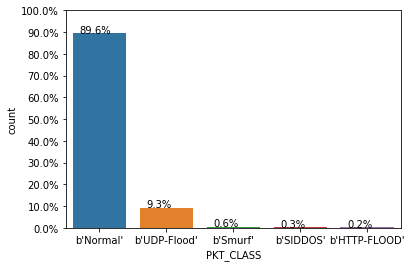

In [ ]:

total = len(df)*1.
ax=sns.countplot(x="PKT_CLASS", data=df)
for p in ax.patches:
        ax.annotate('{:.1f}%'.format(100*p.get_height()/total), (p.get_x()+0.1, p.get_height()+5))

#put 11 ticks (therefore 10 steps), from 0 to the total number of rows in the dataframe
ax.yaxis.set_ticks(np.linspace(0, total, 11))

#adjust the ticklabel to the desired format, without changing the position of the ticks. 
ax.set_yticklabels(map('{:.1f}%'.format, 100*ax.yaxis.get_majorticklocs()/total))
plt.show()

Observation

while analyzing the distribution of the Dataset we observed that The dataset is imbalance as the dataset is based on live network logs and most of the times the services are having normal traffic and attacks are not very often hence the logs have captured mostly normal traffic having almost 89% normal traffic i.e. label-0 and 11% of attacks, among 11% of network attack 9% is “UPD-flood” i.e. label-1 attack and rest type of the attacks are having below 1% occurrence

Running small functions to convert class label which is in bytes into int and also convert categoric data of class label into numberical

In [ ]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    
    phrase = re.sub(r"\'", "", phrase)
    phrase = re.sub(r"^b", "", phrase)
    phrase = re.sub(r"-", "_", phrase)
    #phrase = re.sub(r"_______", "0", phrase)
    #phrase = re.sub(r"___A___", "1", phrase)
    return phrase

In [ ]:
def decontracted2(phrase):
    # specific
    
    phrase = re.sub(r"\'", "", phrase)
    phrase = re.sub(r"^b", "", phrase)
    phrase = re.sub(r"-", "_", phrase)
    phrase = re.sub(r"_______", "0", phrase)
    phrase = re.sub(r"___A___", "1", phrase)
    return phrase

In [ ]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted1(phrase):
    # specific
    
    phrase = re.sub(r"normal", "0", phrase)
    phrase = re.sub(r"udp_flood", "1", phrase)
    phrase = re.sub(r"smurf", "2", phrase)
    phrase = re.sub(r"siddos", "3", phrase)
    phrase = re.sub(r"http_flood", "4", phrase)
    return phrase

In [ ]:
from tqdm import tqdm
def preprocess_text(text_data):
    preprocessed_text = []
    # tqdm is for printing the status bar
    for sentance in tqdm(text_data):
        sent = decontracted(str(sentance))
        
        preprocessed_text.append(sent.lower().strip())
    return preprocessed_text

In [ ]:
from tqdm import tqdm
def preprocess_text2(text_data):
    preprocessed_text = []
    # tqdm is for printing the status bar
    for sentance in tqdm(text_data):
        sent = decontracted2(str(sentance))
        
        preprocessed_text.append(int(sent.lower().strip()))
    return preprocessed_text

In [ ]:
from tqdm import tqdm
def preprocess_text1(text_data):
    preprocessed_text = []
    # tqdm is for printing the status bar
    for sentance in tqdm(text_data):
        sent = decontracted1((sentance))
        
        preprocessed_text.append(int(sent.lower().strip()))
    return preprocessed_text

In [ ]:
df['PKT_CLASS'] = preprocess_text(df['PKT_CLASS'].values)

100%|████████████████████████████████████████████████████████████████████| 2160668/2160668 [00:07<00:00, 289808.88it/s]


In [ ]:
df['PKT_CLASS'] = preprocess_text1(df['PKT_CLASS'].values)

100%|████████████████████████████████████████████████████████████████████| 2160668/2160668 [00:09<00:00, 231296.42it/s]


In [ ]:
df['FLAGS'] = preprocess_text2(df['FLAGS'].values)

100%|████████████████████████████████████████████████████████████████████| 2160668/2160668 [00:11<00:00, 180391.04it/s]


In [ ]:
df['NODE_NAME_FROM'] = preprocess_text(df['NODE_NAME_FROM'].values)

100%|████████████████████████████████████████████████████████████████████| 2160668/2160668 [00:07<00:00, 281646.24it/s]


In [ ]:
df['NODE_NAME_TO'] = preprocess_text(df['NODE_NAME_TO'].values)

100%|████████████████████████████████████████████████████████████████████| 2160668/2160668 [00:07<00:00, 286161.94it/s]


In [ ]:
df['PKT_TYPE'] = preprocess_text(df['PKT_TYPE'].values)

100%|████████████████████████████████████████████████████████████████████| 2160668/2160668 [00:07<00:00, 295487.59it/s]


In [ ]:
df.head()

,SRC_ADD,DES_ADD,PKT_ID,FROM_NODE,TO_NODE,PKT_TYPE,PKT_SIZE,FLAGS,FID,SEQ_NUMBER,...,PKT_RATE,BYTE_RATE,PKT_AVG_SIZE,UTILIZATION,PKT_DELAY,PKT_SEND_TIME,PKT_RESEVED_TIME,FIRST_PKT_SENT,LAST_PKT_RESEVED,PKT_CLASS
0,3.00,24.30,389693.0,21.0,23.0,tcp,1540.0,0,4.0,11339.0,...,328.240918,505490.0,1540.0,0.236321,0.0,35.519662,35.550032,1.000000,50.021920,0
1,15.00,24.15,201196.0,23.0,24.0,tcp,1540.0,0,16.0,6274.0,...,328.205808,505437.0,1540.0,0.236337,0.0,20.156478,20.186848,1.000000,50.030211,0
2,24.15,15.00,61905.0,23.0,22.0,ack,55.0,0,16.0,1930.0,...,328.206042,18051.3,55.0,0.008441,0.0,7.039952,7.069962,1.030045,50.060221,1
3,24.90,9.00,443135.0,23.0,21.0,ack,55.0,0,10.0,12670.0,...,328.064183,18043.5,55.0,0.008437,0.0,39.617967,39.647976,1.030058,50.060098,0
4,24.80,8.00,157335.0,23.0,21.0,ack,55.0,0,9.0,4901.0,...,328.113525,18046.2,55.0,0.008438,0.0,16.029803,16.059813,1.030054,50.061864,0


In [ ]:
#df.to_csv("Processed_df.csv",index=False)

In [ ]:
df=pd.read_csv("Processed_df.csv")
df.head()

,SRC_ADD,DES_ADD,PKT_ID,FROM_NODE,TO_NODE,PKT_TYPE,PKT_SIZE,FLAGS,FID,SEQ_NUMBER,...,PKT_RATE,BYTE_RATE,PKT_AVG_SIZE,UTILIZATION,PKT_DELAY,PKT_SEND_TIME,PKT_RESEVED_TIME,FIRST_PKT_SENT,LAST_PKT_RESEVED,PKT_CLASS
0,3.00,24.30,389693.0,21.0,23.0,tcp,1540.0,0,4.0,11339.0,...,328.240918,505490.0,1540.0,0.236321,0.0,35.519662,35.550032,1.000000,50.021920,0
1,15.00,24.15,201196.0,23.0,24.0,tcp,1540.0,0,16.0,6274.0,...,328.205808,505437.0,1540.0,0.236337,0.0,20.156478,20.186848,1.000000,50.030211,0
2,24.15,15.00,61905.0,23.0,22.0,ack,55.0,0,16.0,1930.0,...,328.206042,18051.3,55.0,0.008441,0.0,7.039952,7.069962,1.030045,50.060221,1
3,24.90,9.00,443135.0,23.0,21.0,ack,55.0,0,10.0,12670.0,...,328.064183,18043.5,55.0,0.008437,0.0,39.617967,39.647976,1.030058,50.060098,0
4,24.80,8.00,157335.0,23.0,21.0,ack,55.0,0,9.0,4901.0,...,328.113525,18046.2,55.0,0.008438,0.0,16.029803,16.059813,1.030054,50.061864,0


Observation
converted class label from bytes to int and also convert categoric data into numberical
Also have converted the FLAG attribute into binary

### Correlation Matrix with Heatmap

Correlation states how the features are related to each other or the target variable

checking for correlation between all the attributes except the categoricall attributes 
attributes like PKT_IN,PKT_OUT,PKT_R,Packet_sent_time & Packet_recieve_time are having possitive correlation and we can avoid such attributes, However we can also double check with feature importance from ExtraTreesClassifier to get top 10 attributes to be used

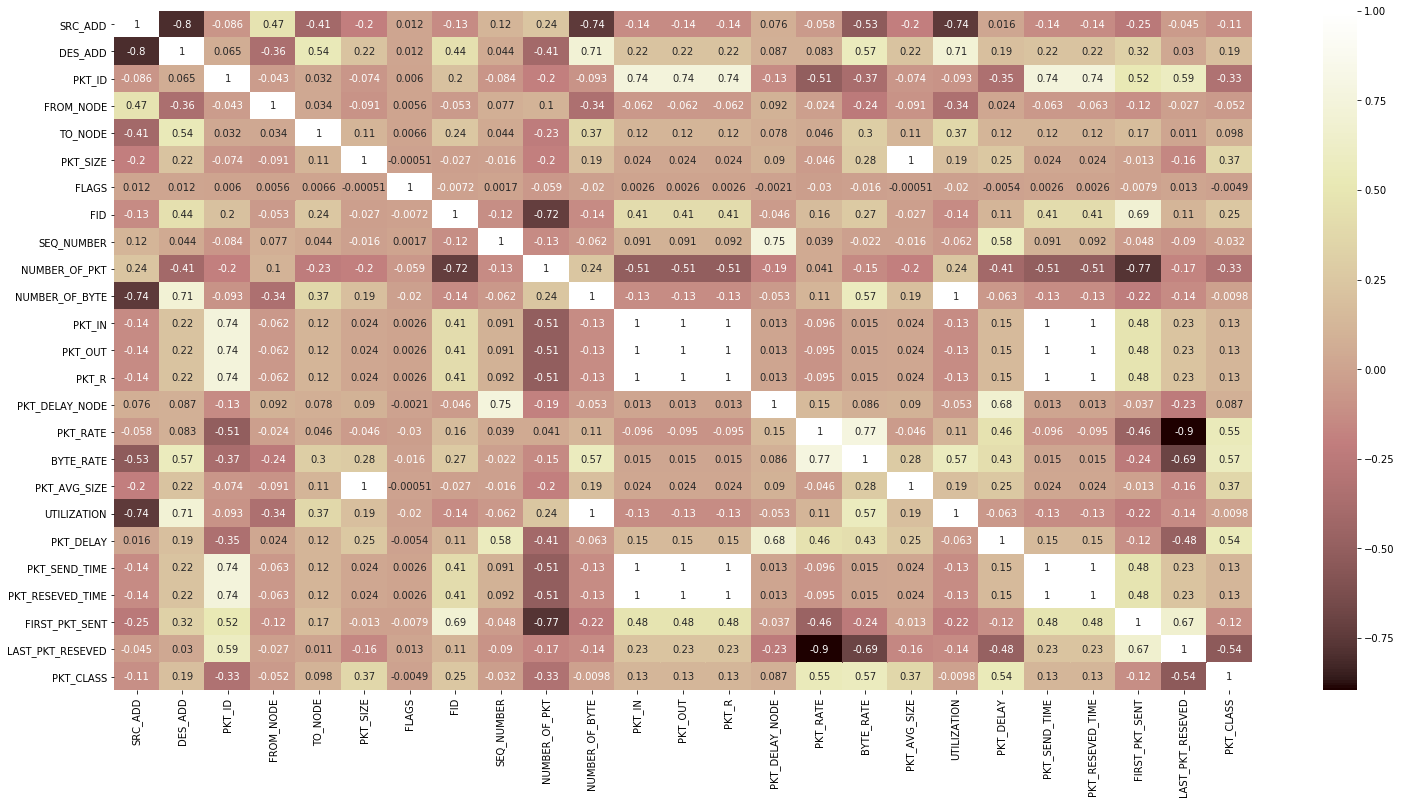

In [ ]:
dfcorr=df.corr()
plt.figure(figsize=[25.5,12.5])
sns.heatmap(dfcorr,annot=True,cmap='pink')
plt.show()

### Feature Importance

can get the feature importance of each feature of your dataset by using the feature importance property of the model.
Feature importance gives you a score for each feature of your data, the higher the score more important or relevant is the feature towards your output variable.
Feature importance is an inbuilt class that comes with Tree Based Classifiers, we will be using Extra Tree Classifier for extracting the top 10 features for the dataset

In [ ]:
y = df['PKT_CLASS'].values    # separated the class label in Y
X = df.drop(['PKT_TYPE','PKT_CLASS','NODE_NAME_FROM','NODE_NAME_TO'], axis=1)   # combined all the numerical features into X
X.head(1)

,SRC_ADD,DES_ADD,PKT_ID,FROM_NODE,TO_NODE,PKT_SIZE,FLAGS,FID,SEQ_NUMBER,NUMBER_OF_PKT,...,PKT_RATE,BYTE_RATE,PKT_AVG_SIZE,UTILIZATION,PKT_DELAY,PKT_SEND_TIME,PKT_RESEVED_TIME,FIRST_PKT_SENT,LAST_PKT_RESEVED,new_label
0,3.0,24.3,389693.0,21.0,23.0,1540.0,0,4.0,11339.0,16091.0,...,328.240918,505490.0,1540.0,0.236321,0.0,35.519662,35.550032,1.0,50.02192,0


In [ ]:
df_new = df.drop(['PKT_TYPE','NODE_NAME_FROM','NODE_NAME_TO'], axis=1)

In [ ]:
df_new.shape,df.shape

((2160668, 26), (2160668, 29))

[1.23709645e-02 2.13605271e-02 5.75719898e-02 1.50382097e-03
 1.52628046e-03 1.51477394e-02 1.57542637e-05 3.09191178e-02
 2.54604439e-02 5.91186916e-02 2.40358843e-02 2.07256844e-02
 2.09795133e-02 2.39521035e-02 4.34678475e-03 2.17379349e-01
 1.64869279e-01 1.53057551e-02 2.61757676e-02 2.10905866e-02
 2.01464494e-02 2.64201632e-02 3.54858622e-02 1.54091487e-01]


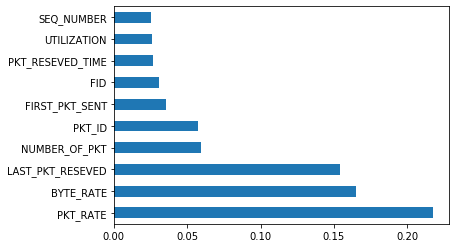

In [ ]:
#ref#https://towardsdatascience.com/feature-selection-techniques-in-machine-learning-with-python-f24e7da3f36e#:~:text=Feature%20Selection%20is%20the%20process,learn%20based%20on%20irrelevant%20features.

from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
model = ExtraTreesClassifier()
model.fit(X,y)
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

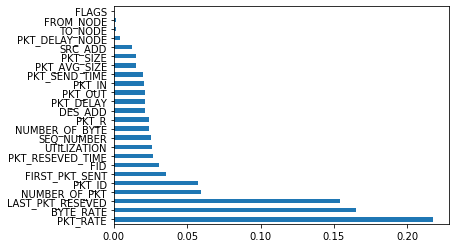

In [ ]:
feat_importances.nlargest(26).plot(kind='barh')

Along with the top 10 features we have also three categorical features like PKT_TYPE,NODE_NAME_FROM & NODE_NAME_TO which we will be using.

### Univariate analysis

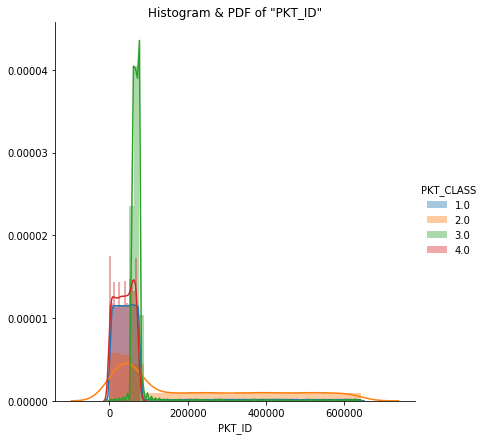

In [ ]:

sns.FacetGrid(df_new,hue='PKT_CLASS',size=6) \
   .map(sns.distplot,'PKT_ID') \
   .add_legend();
plt.title('Histogram & PDF of "PKT_ID"')
plt.show();

Text(0, 0.5, 'PKT_ID')

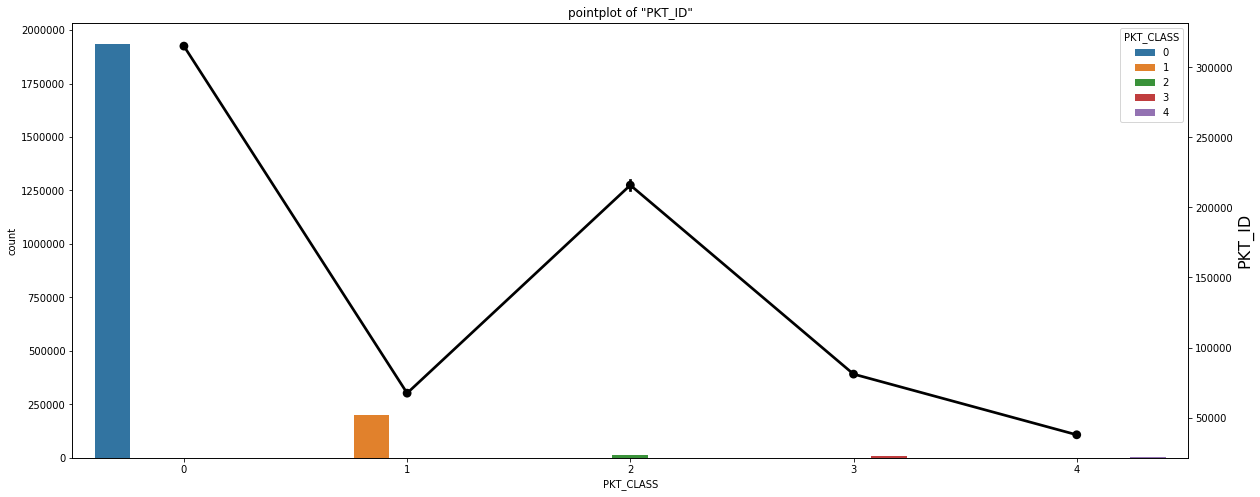

In [ ]:
plt.figure(figsize=(20,8))
g1 = sns.countplot(x='PKT_CLASS', hue='PKT_CLASS', data=df)
gt = g1.twinx()
gt = sns.pointplot(y='PKT_ID', x='PKT_CLASS', data=df, color='black', legend=False)
plt.title('pointplot of "PKT_ID"')
gt.set_ylabel("PKT_ID", fontsize=16)

First observation is for the PDF data points are overlapping for PKT_ID attribute with respect to the class label we don't get much clearification

While checking the pointplot upon the class label we can see that for Normal traffic i.e. label-0 we have higher packet ID  while class label-1, label-2, label-3, label-4 are also having different pkt_ids and can be classified almost clearly specically class label-0,2,and 4 can be clearly classified
there is drift in the flow of bits and flow of packets during a DDoS attack compared to a Benign or Safe connection.

We could clearly observe that there is drift in the flow of PKT_ID during a DDoS attack compared to a  Safe connection or normal traffic.

Text(0, 0.5, 'FID')

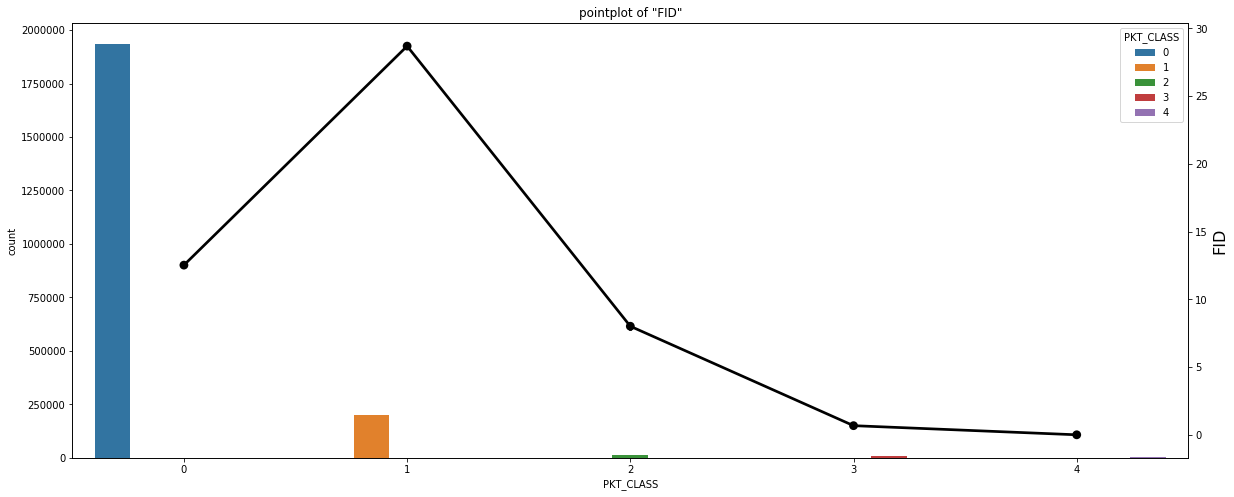

In [ ]:
plt.figure(figsize=(20,8))
g1 = sns.countplot(x='PKT_CLASS', hue='PKT_CLASS', data=df)
gt = g1.twinx()
gt = sns.pointplot(y='FID', x='PKT_CLASS', data=df, color='black', legend=False)
plt.title('pointplot of "FID"')
gt.set_ylabel("FID", fontsize=16)

Observation
while observing the flow of the attribute FID can also distinguish between all the class labels as not only normal traffic has a drift also other types of attacks can be categorized 
However for HTTP-Flood or class label-3, SIDDOS class label-4 are in the same range i.e. in between 0-2
However rest all the class labels can be clearly classified 

Text(0, 0.5, 'NUMBER_OF_BYTE')

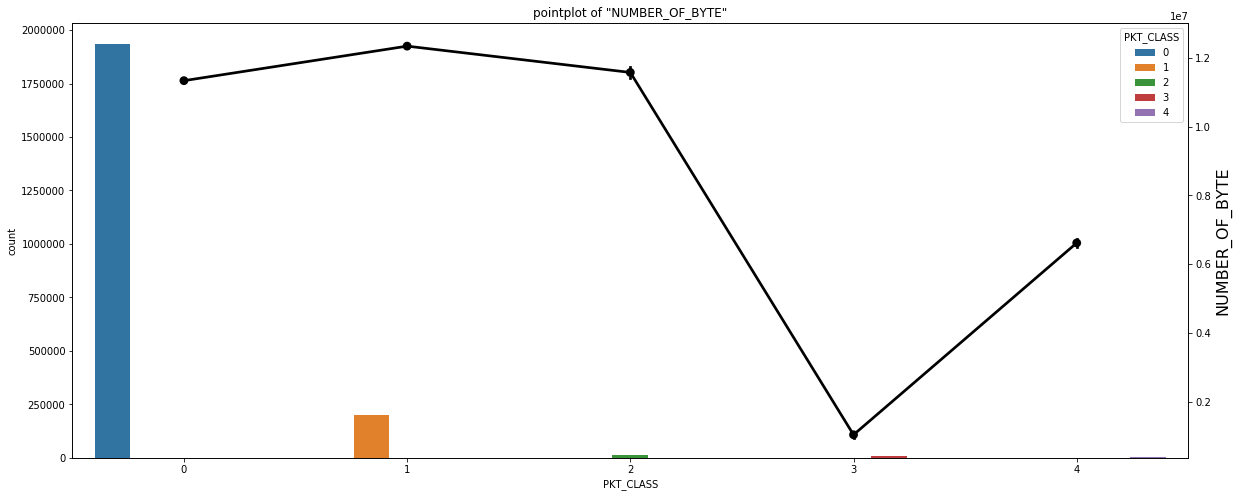

In [ ]:
plt.figure(figsize=(20,8))
g1 = sns.countplot(x='PKT_CLASS', hue='PKT_CLASS', data=df)
gt = g1.twinx()
gt = sns.pointplot(y='NUMBER_OF_BYTE', x='PKT_CLASS', data=df, color='black', legend=False)
plt.title('pointplot of "NUMBER_OF_BYTE"')
gt.set_ylabel("NUMBER_OF_BYTE", fontsize=16)

For NUMBER_OF_BYTE attribute we can see all the Normal,UDP-flood,Smurf class label can't be clearly classified as the average points of this attributes lies in same range with respect to NUMBER_OF_BYTE attribute However we can see that rest two class labels can be clearly classified as Avg SIDDOS points is in the range of 0.1 and HTTP-Flood is 0.5

Text(0, 0.5, 'PKT_RATE')

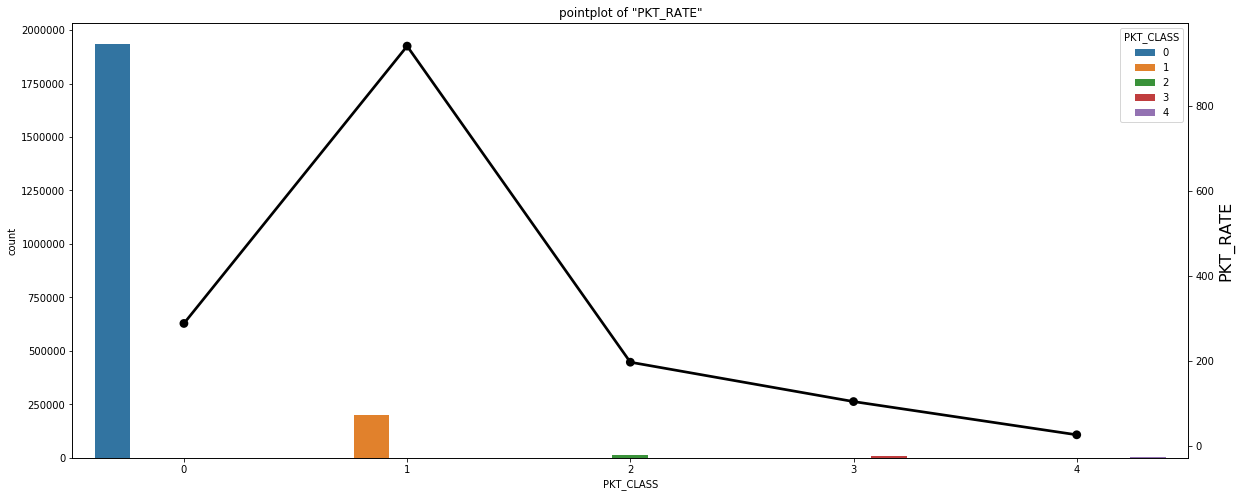

In [ ]:
plt.figure(figsize=(20,8))
g1 = sns.countplot(x='PKT_CLASS', hue='PKT_CLASS', data=df)
gt = g1.twinx()
gt = sns.pointplot(y='PKT_RATE', x='PKT_CLASS', data=df, color='black', legend=False)
plt.title('pointplot of "PKT_RATE"')
gt.set_ylabel("PKT_RATE", fontsize=16)

Observation 
For attribute PKT_RATE we can clearly segregate all the class label with respect to the avg points of the PKT_Rate attribute
while Feature Importance we also observed that this attribute was having the highest score which mean more important or relevant of the feature towards your output variable.

Text(0, 0.5, 'BYTE_RATE')

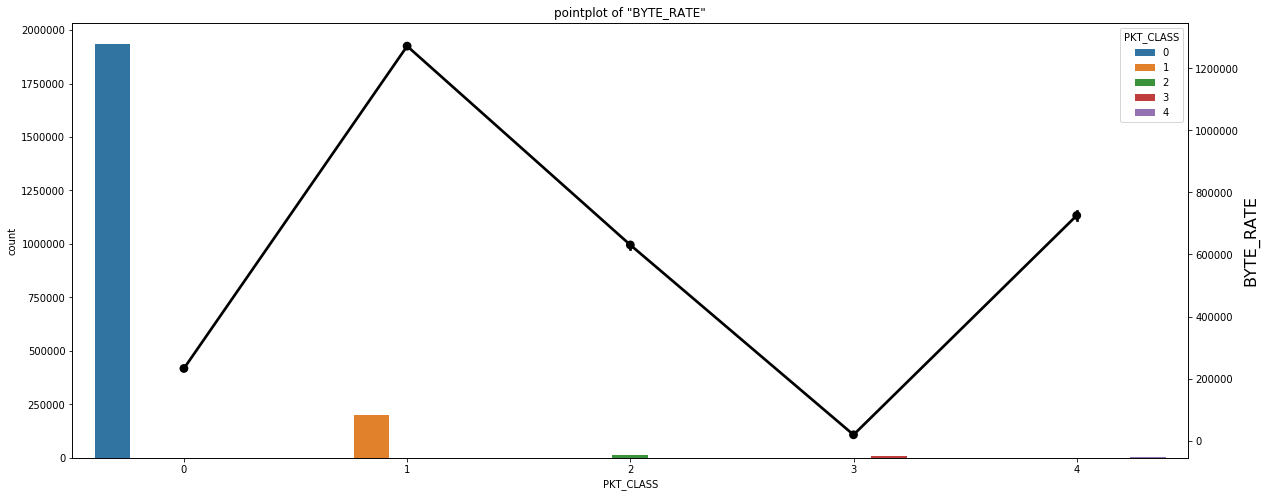

In [ ]:
plt.figure(figsize=(20,8))
g1 = sns.countplot(x='PKT_CLASS', hue='PKT_CLASS', data=df)
gt = g1.twinx()
gt = sns.pointplot(y='BYTE_RATE', x='PKT_CLASS', data=df, color='black', legend=False)
plt.title('pointplot of "BYTE_RATE"')
gt.set_ylabel("BYTE_RATE", fontsize=16)

Observation 
For attribute BYTE_RATE we can moslty segregate the class labels with the avg points and all the class labels can be clearly classified 
while checking the Feature Importance this attribute was the second most important attribute and will be useful in classification task


Text(0, 0.5, 'UTILIZATION')

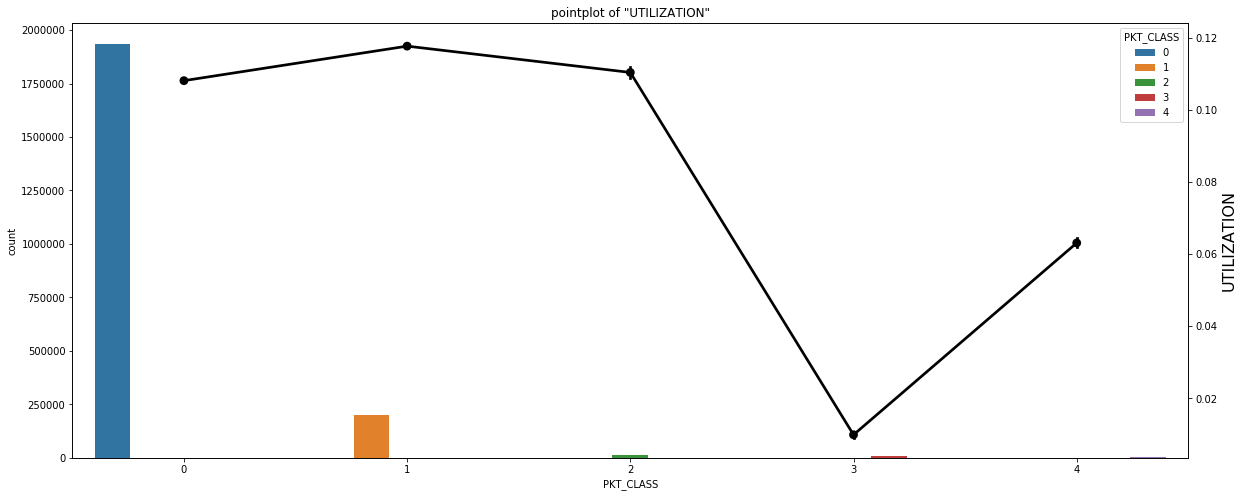

In [ ]:
plt.figure(figsize=(20,8))
g1 = sns.countplot(x='PKT_CLASS', hue='PKT_CLASS', data=df)
gt = g1.twinx()
gt = sns.pointplot(y='UTILIZATION', x='PKT_CLASS', data=df, color='black', legend=False)
plt.title('pointplot of "UTILIZATION"')
gt.set_ylabel("UTILIZATION", fontsize=16)

Observation

All the the class label are not able to be segregate however SIDDOS and HTTP-flood categories of the class label can be classified cleared

Text(0, 0.5, 'LAST_PKT_RESEVED')

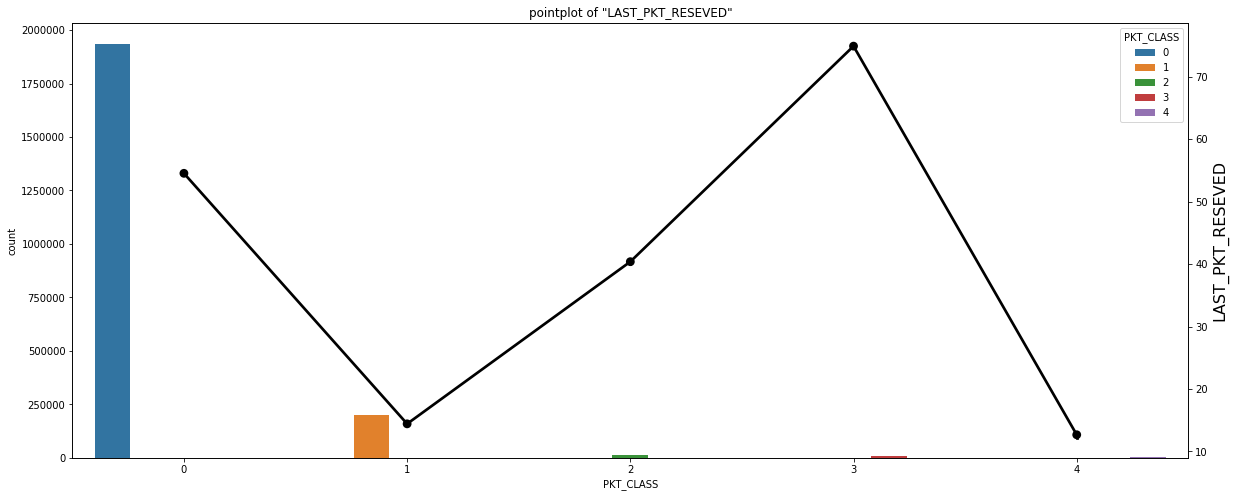

In [ ]:
plt.figure(figsize=(20,8))
g1 = sns.countplot(x='PKT_CLASS', hue='PKT_CLASS', data=df)
gt = g1.twinx()
gt = sns.pointplot(y='LAST_PKT_RESEVED', x='PKT_CLASS', data=df, color='black', legend=False)
plt.title('pointplot of "LAST_PKT_RESEVED"')
gt.set_ylabel("LAST_PKT_RESEVED", fontsize=16)

Observation 
For LAST_PKT_RESEVED attribute we can segregate class labels clearly with the avg points of the attribute,  however few class label will be hard to classification with LAST_PKT_RESEVED however almost all the class labe can be classified

Text(0, 0.5, 'NUMBER_OF_PKT')

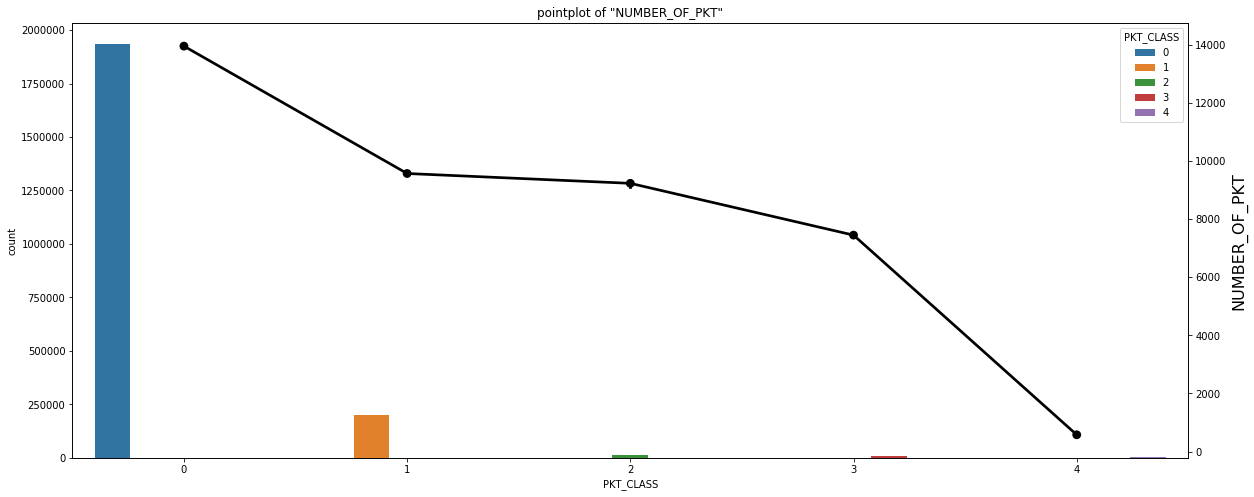

In [ ]:
plt.figure(figsize=(20,8))
g1 = sns.countplot(x='PKT_CLASS', hue='PKT_CLASS', data=df)
gt = g1.twinx()
gt = sns.pointplot(y='NUMBER_OF_PKT', x='PKT_CLASS', data=df, color='black', legend=False)
plt.title('pointplot of "NUMBER_OF_PKT"')
gt.set_ylabel("NUMBER_OF_PKT", fontsize=16)

Observation
Foe attribute NUMBER_OF_PKT we can see the pointplot we can segregate clearly with some difficulties with few class labels however rest of the class labels can be classified clearly.


Text(0, 0.5, 'PKT_DELAY')

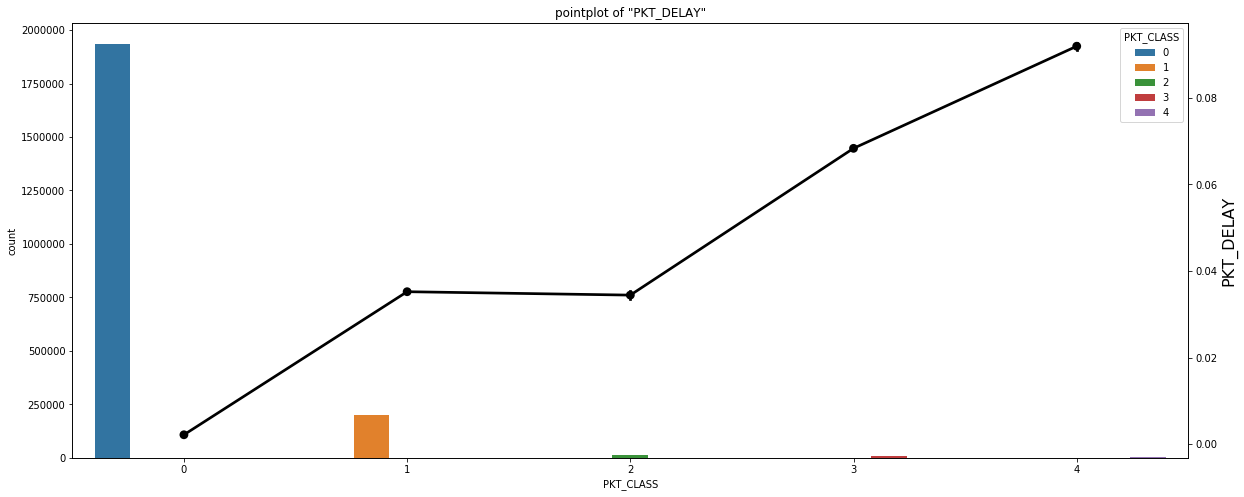

In [ ]:
plt.figure(figsize=(20,8))
g1 = sns.countplot(x='PKT_CLASS', hue='PKT_CLASS', data=df)
gt = g1.twinx()
gt = sns.pointplot(y='PKT_DELAY', x='PKT_CLASS', data=df, color='black', legend=False)
plt.title('pointplot of "PKT_DELAY"')
gt.set_ylabel("PKT_DELAY", fontsize=16)

Observation
Foe attribute PKT_DELAY we can see the pointplot we can segregate clearly with some difficulties with  class label 1 and 2 however rest of the class labels can be classified clearly.

Text(0, 0.5, 'FIRST_PKT_SENT')

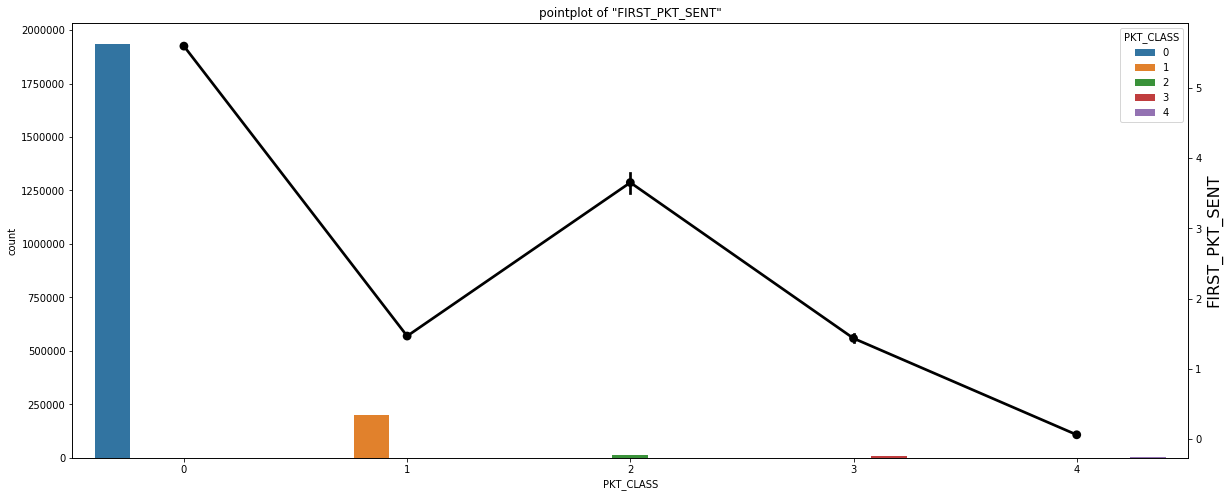

In [ ]:
plt.figure(figsize=(20,8))
g1 = sns.countplot(x='PKT_CLASS', hue='PKT_CLASS', data=df)
gt = g1.twinx()
gt = sns.pointplot(y='FIRST_PKT_SENT', x='PKT_CLASS', data=df, color='black', legend=False)
plt.title('pointplot of "FIRST_PKT_SENT"')
gt.set_ylabel("FIRST_PKT_SENT", fontsize=16)

Observation
Foe attribute NUMBER_OF_PKT we can see the pointplot we can segregate clearly with some difficulties with few class labels 1 and 3, however rest of the class labels can be classified clearly.

### Boxplots

Text(0.5, 1.0, 'Boxplot of "PKT_DELAY"')

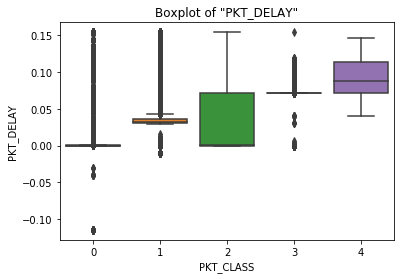

In [ ]:
sns.boxplot(x='PKT_CLASS',
    y='PKT_DELAY',
    data=df,)
plt.title('Boxplot of "PKT_DELAY"')

As already observed in Univariate analysis all the attributes were able to classify except class label 1 and 2  
While checking the Box plot we can see that  the class labels 1 with respect to the packet delay doesn't delay at all with some exceptions, However for class label 1 can see 75% delay is in side 0.04 and for class label 2  50% delay is in between 0.01 and we can see there are outliers for bothe the class labels with respect to delay 

Text(0.5, 1.0, 'Boxplot of "UTILIZATION"')

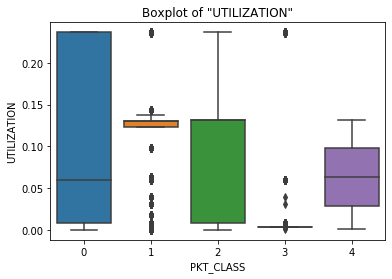

In [ ]:
sns.boxplot(x='PKT_CLASS',
    y='UTILIZATION',
    data=df,)
plt.title('Boxplot of "UTILIZATION"')

While observing the box plot for the UTILIZATION attribute we can see among all the class labels categories 25-75% to data points for class label-0,1,2,4 are in simillar range and so while analyzing the UTILIZATION attribute in ponint plot we were having difficulties to classify those class labels, however we can clearly classifies class labels-3 are  most of th data lies in 0.00-0.01 baring few exceptions

Text(0.5, 1.0, 'Boxplot of "NUMBER_OF_PKT"')

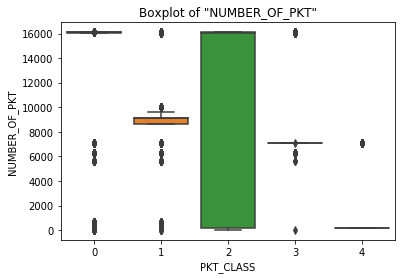

In [ ]:
sns.boxplot(x='PKT_CLASS',
    y='NUMBER_OF_PKT',
    data=df,)
plt.title('Boxplot of "NUMBER_OF_PKT"')

While analyzing the Box plot for NUMBER_OF_PKT attribute we can see that class label-0 is having all the pkts at the range of 16000 baring few outiers and for class-1,3&4 can be segregated as 25-75% of the date of the respected class labels are in diffrent range however for class label-2 75% of the the data varries inbetween 0-16000 in inside overall sectrum

Text(0.5, 1.0, 'Boxplot of "NUMBER_OF_BYTE"')

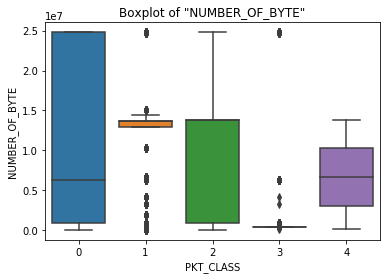

In [ ]:


sns.boxplot(x='PKT_CLASS',
    y='NUMBER_OF_BYTE',
    data=df,)
plt.title('Boxplot of "NUMBER_OF_BYTE"')

while analyzing the Boxplot for NUMBER_OF_BYTE attributes we can see only class label-3 25-75% of thr data lies in 0.00-0.01, while all the class labels are sharing a distribution where the 25-75% range of data over laps eachother 

Text(0.5, 1.0, 'Boxplot of "PKT_ID"')

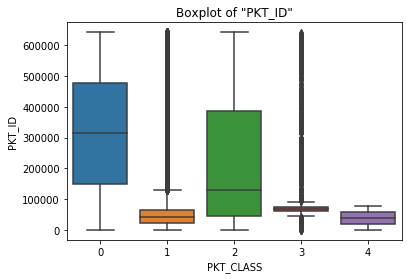

In [ ]:
sns.boxplot(x='PKT_CLASS',
    y='PKT_ID',
    data=df,)
plt.title('Boxplot of "PKT_ID"')


While analyzing the Boxplot for the PKT_ID attribute we can see that the class label-0 is having 25-75% in a different range then other class labels and can be clearly classified however other class labels are in simmilar range.

### Bivariate analysis

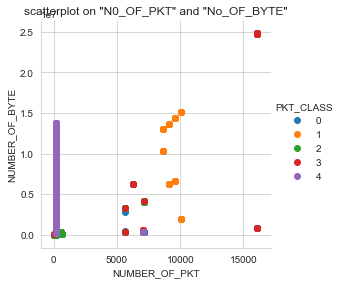

In [ ]:

sns.set_style("whitegrid");
sns.FacetGrid(df, hue="PKT_CLASS", size=4) \
   .map(plt.scatter, "NUMBER_OF_PKT", "NUMBER_OF_BYTE") \
   .add_legend();
plt.title('scatterplot on "N0_OF_PKT" and "No_OF_BYTE"')
plt.show();

Observation
while doing bi-variate analysis of NUMBER_OF_PKT attribute and NUMBER_OF_BYTE attribute on target variable we can see that the class label-1 can be clearly seperated from the rest and by some extend for label-3 and 4 can be seperated but for label-2 and 0 its hard to ditinguish as all of label-0 overlapps with label-3 where label-2 overlaps with label-4

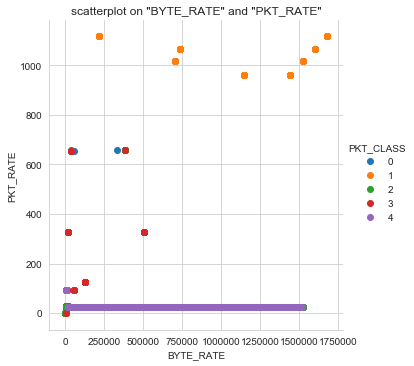

In [ ]:
sns.set_style("whitegrid");
sns.FacetGrid(df, hue="PKT_CLASS", size=5) \
   .map(plt.scatter, "BYTE_RATE", "PKT_RATE") \
   .add_legend();
plt.title('scatterplot on "BYTE_RATE" and "PKT_RATE"')
plt.show();

Observation
while doing bi-variate analysis on BYTE_RATE attribute and PKT_RATE attribute on target variable we can see that the class label-1,4,3 can be clearly seperated from the rest of the labels and label-0 can also almost seperated from label-3, however label-2 totaly overlaps in between label-4 & 3

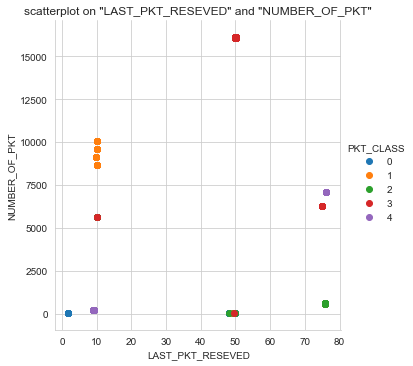

In [ ]:
sns.set_style("whitegrid");
sns.FacetGrid(df, hue="PKT_CLASS", size=5) \
   .map(plt.scatter, "LAST_PKT_RESEVED", "LAST_PKT_RESEVED") \
   .add_legend();
plt.title('scatterplot on "LAST_PKT_RESEVED" and "NUMBER_OF_PKT"')
plt.show();

Observation
while doing bi-variate analysis of LAST_PKT_RESEVED attribute and LAST_PKT_RESEVED attribute on target variable we can see that the all the class labels can be seperated however there is some overlap for label-2 and 3 still the class labels are well seperated

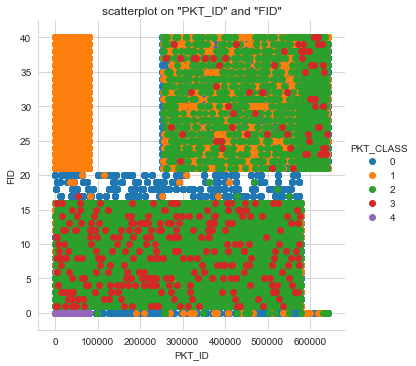

In [ ]:
sns.set_style("whitegrid");
sns.FacetGrid(df, hue="PKT_CLASS", size=5) \
   .map(plt.scatter, "PKT_ID", "FID") \
   .add_legend();
plt.title('scatterplot on "PKT_ID" and "FID"')
plt.show();

Observation
while doing bi-variate analysis of PKT_ID attribute and FID attribute on target variable we can see that the most of the labels are overlaped and for label-1 and 0 almost all the points are almost seperated however rest all the labels are overlapped and most of the points are so densly overlapped we can't have any idea how to seperat rest of the labels

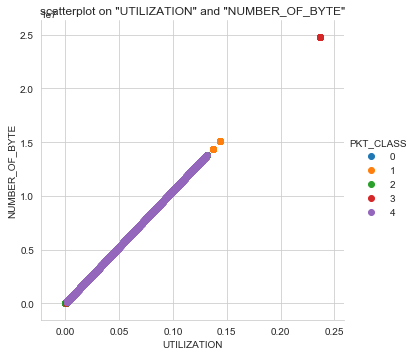

In [ ]:
sns.set_style("whitegrid");
sns.FacetGrid(df, hue="PKT_CLASS", size=5) \
   .map(plt.scatter, "UTILIZATION", "NUMBER_OF_BYTE") \
   .add_legend();
plt.title('scatterplot on "UTILIZATION" and "NUMBER_OF_BYTE"')
plt.show();

Observation
while doing bi-variate analysis of UTILIZATION attribute and NUMBER_OF_BYTE attribute on target variable we can see that all of the data points in all labels are overlapped except some points in label-1 and label-3

In [ ]:
df['NUMBER_OF_PKT'].quantile(q=0.2)

7110.0

In [ ]:
df['NUMBER_OF_PKT'][[df[['NUMBER_OF_PKT','PKT_DELAY']] < np.percentile(df['NUMBER_OF_PKT'],95)] and df['NUMBER_OF_PKT']> np.percentile(df['NUMBER_OF_PKT'],5)]

0          16091.0
1          16092.0
2          16092.0
3          16085.0
4          16088.0
            ...   
2160663    16103.0
2160664    16103.0
2160665    16091.0
2160666    16091.0
2160667    16092.0
Name: NUMBER_OF_PKT, Length: 1747685, dtype: float64

### T-SNE

In [ ]:
new=df.iloc[0:10000]# taking a small set of data for running T-sne 

Tried to pick only the Important Feature attributes.

In [ ]:
y = new['PKT_CLASS'].values    # separated the class label in Y
X = new.drop(['PKT_TYPE','PKT_CLASS','NODE_NAME_FROM','NODE_NAME_TO'
             ,"SRC_ADD",'DES_ADD','FROM_NODE','TO_NODE','TO_NODE',
             "PKT_SIZE",'FLAGS','SEQ_NUMBER','PKT_IN','PKT_OUT','PKT_R',
             'PKT_DELAY_NODE','PKT_AVG_SIZE','PKT_SEND_TIME','PKT_RESEVED_TIME'], axis=1)   # combined all the features into X
X.head(1)

,PKT_ID,FID,NUMBER_OF_PKT,NUMBER_OF_BYTE,PKT_RATE,BYTE_RATE,UTILIZATION,PKT_DELAY,FIRST_PKT_SENT,LAST_PKT_RESEVED
0,389693.0,4.0,16091.0,24780100.0,328.240918,505490.0,0.236321,0.0,1.0,50.02192


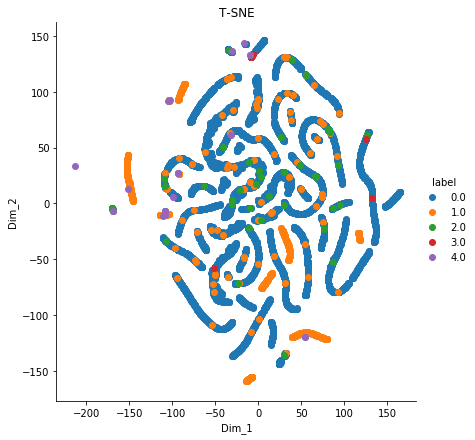

In [ ]:
from sklearn.manifold import TSNE
model = TSNE(n_components=2, random_state=0, perplexity=20,n_iter=2000,learning_rate=500.0)
tsne_data = model.fit_transform(X) 

# creating a new data fram which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, y)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('T-SNE')
plt.show()

Running T-sne on important feartures we can classify the label-0&1 almost cleary grouped and label-1 can be clearly clustered However difficulty in grouping label-2,3,4 still we can see label-3&4 are better clusterd or grouped while using the important features and label-2 is hardest to group.

However Unsupervised algorithims with a balanced dataset would perform great as we know data is imbalanced and this may lead to this poor performance of the T-sne.

### Conclusion

Most of the attributes we have checks would helps us to classify the class label as we have analyzed in every attribtes have either clearly classified the normal label from the attack labels or have segregrate all the class labels clearly However we can see the dataset is imbalanced and few classlabels are have less the 1% datapoints upsampling of the data  would give us  better results and certainly helps us with supervised learning algorithims techniques

### Classifing normal and all types of attack into Binary classification

In [3]:
df.head()

,SRC_ADD,DES_ADD,PKT_ID,FROM_NODE,TO_NODE,PKT_TYPE,PKT_SIZE,FLAGS,FID,SEQ_NUMBER,...,PKT_RATE,BYTE_RATE,PKT_AVG_SIZE,UTILIZATION,PKT_DELAY,PKT_SEND_TIME,PKT_RESEVED_TIME,FIRST_PKT_SENT,LAST_PKT_RESEVED,PKT_CLASS
0,3.00,24.30,389693.0,21.0,23.0,tcp,1540.0,0,4.0,11339.0,...,328.240918,505490.0,1540.0,0.236321,0.0,35.519662,35.550032,1.000000,50.021920,0
1,15.00,24.15,201196.0,23.0,24.0,tcp,1540.0,0,16.0,6274.0,...,328.205808,505437.0,1540.0,0.236337,0.0,20.156478,20.186848,1.000000,50.030211,0
2,24.15,15.00,61905.0,23.0,22.0,ack,55.0,0,16.0,1930.0,...,328.206042,18051.3,55.0,0.008441,0.0,7.039952,7.069962,1.030045,50.060221,1
3,24.90,9.00,443135.0,23.0,21.0,ack,55.0,0,10.0,12670.0,...,328.064183,18043.5,55.0,0.008437,0.0,39.617967,39.647976,1.030058,50.060098,0
4,24.80,8.00,157335.0,23.0,21.0,ack,55.0,0,9.0,4901.0,...,328.113525,18046.2,55.0,0.008438,0.0,16.029803,16.059813,1.030054,50.061864,0


In [4]:
def binary_classification(a):
    new_class=[]
    for i in a:    
        if i==0:
            new_class.append(0)
        else:
            new_class.append(1)
    return new_class
        

In [5]:
new_class=binary_classification(df['PKT_CLASS'])

In [6]:
df['new_class']=new_class

In [7]:
from sklearn.preprocessing import LabelEncoder
LE=LabelEncoder()

In [13]:
PKT_TYPE_=LE.fit(df['PKT_TYPE'])

In [16]:
NODE_NAME_FROM_=LE.fit(df['NODE_NAME_FROM'])

In [18]:
NODE_NAME_TO_=LE.fit(df['NODE_NAME_TO'])

In [11]:
# Save the Modle to file in the current working directory

PKT_TYPE_LE = "PKT_TYPE_LE.pkl"  

#with open(PKT_TYPE_LE, 'wb') as file:  
    #pickle.dump(PKT_TYPE_, file)

In [206]:
# Save the Modle to file in the current working directory

NODE_NAME_FROM_LE = "NODE_NAME_FROM_LE.pkl"  

#with open(NODE_NAME_FROM_LE, 'wb') as file:  
    #pickle.dump(NODE_NAME_FROM_, file)

In [209]:
# Save the Modle to file in the current working directory

NODE_NAME_TO_LE = "NODE_NAME_TO_LE.pkl"  

#with open(NODE_NAME_TO_LE, 'wb') as file:  
    #pickle.dump(NODE_NAME_TO_, file)

In [15]:
PKT_TYPE=PKT_TYPE_.transform(df['PKT_TYPE'])

In [17]:

NODE_NAME_FROM=NODE_NAME_FROM_.transform(df['NODE_NAME_FROM'])


In [19]:
NODE_NAME_TO=NODE_NAME_TO_.transform(df['NODE_NAME_TO'])

In [20]:
df['PKT_TYPE_encode']=PKT_TYPE
df['NODE_NAME_FROM_encode']=NODE_NAME_FROM
df['NODE_NAME_TO_encode']=NODE_NAME_TO

### Dividing into binary classification between normal and attack traffic

In [21]:
y = df['new_class'].values  # separated the class lable in Y
X = df.drop(['PKT_CLASS','new_class','FLAGS','PKT_TYPE','NODE_NAME_FROM','NODE_NAME_TO'], axis=1)   # combined all the features into X
X.head(1)

,SRC_ADD,DES_ADD,PKT_ID,FROM_NODE,TO_NODE,PKT_SIZE,FID,SEQ_NUMBER,NUMBER_OF_PKT,NUMBER_OF_BYTE,...,PKT_AVG_SIZE,UTILIZATION,PKT_DELAY,PKT_SEND_TIME,PKT_RESEVED_TIME,FIRST_PKT_SENT,LAST_PKT_RESEVED,PKT_TYPE_encode,NODE_NAME_FROM_encode,NODE_NAME_TO_encode
0,3.0,24.3,389693.0,21.0,23.0,1540.0,4.0,11339.0,16091.0,24780100.0,...,1540.0,0.236321,0.0,35.519662,35.550032,1.0,50.02192,3,44,42


In [68]:
# train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20,shuffle=True,stratify=y )

In [69]:
df.columns

Index(['SRC_ADD', 'DES_ADD', 'PKT_ID', 'FROM_NODE', 'TO_NODE', 'PKT_TYPE',
       'PKT_SIZE', 'FLAGS', 'FID', 'SEQ_NUMBER', 'NUMBER_OF_PKT',
       'NUMBER_OF_BYTE', 'NODE_NAME_FROM', 'NODE_NAME_TO', 'PKT_IN', 'PKT_OUT',
       'PKT_R', 'PKT_DELAY_NODE', 'PKT_RATE', 'BYTE_RATE', 'PKT_AVG_SIZE',
       'UTILIZATION', 'PKT_DELAY', 'PKT_SEND_TIME', 'PKT_RESEVED_TIME',
       'FIRST_PKT_SENT', 'LAST_PKT_RESEVED', 'PKT_CLASS', 'new_class',
       'PKT_TYPE_encode', 'NODE_NAME_FROM_encode', 'NODE_NAME_TO_encode'],
      dtype='object')

Need to encode categorical features and normalized the numeric features in order to train model

### encoding numerical features:

In [70]:
def normalizer_1(a):
    from sklearn.preprocessing import StandardScaler
    normalizer_= StandardScaler()
    normalizer_.fit(a.reshape(-1,1))
        

    return normalizer_

In [71]:
def scaler(x):
    scaler=[]
    for i in range(0,x.shape[1]):
        X=x[0:x.shape[0],i:i+1]
        scaler.append(normalizer_1(X))
        
    return (scaler)    
        
    
    

In [72]:
scale=scaler(X_train.values)

In [79]:
# Save the Modle to file in the current working directory

Standardscale = "Standard_scale.pkl"  

with open(Standardscale, 'wb') as file:  
    pickle.dump(scale, file)

In [75]:
def normalizer(a,b):
    
    from sklearn.preprocessing import StandardScaler
    normalizer_= StandardScaler()
    normalizer_.fit(a.reshape(-1,1))
    X_train = normalizer_.transform(a.reshape(-1,1))

    X_test= normalizer_.transform(b.reshape(-1,1))
    return X_train,X_test
    

In [76]:
 X_train['SRC_ADD'],X_test['SRC_ADD']=normalizer(X_train['SRC_ADD'].values,X_test['SRC_ADD'].values)
X_train['DES_ADD'],X_test['DES_ADD']=normalizer(X_train['DES_ADD'].values,X_test['DES_ADD'].values)
X_train['PKT_ID'],X_test['PKT_ID']=normalizer(X_train['PKT_ID'].values,X_test['PKT_ID'].values)

X_train['PKT_SIZE'],X_test['PKT_SIZE']=normalizer(X_train['PKT_SIZE'].values,X_test['PKT_SIZE'].values)
X_train['FID'],X_test['FID']=normalizer(X_train['FID'].values,X_test['FID'].values)
X_train['SEQ_NUMBER'],X_test['SEQ_NUMBER']=normalizer(X_train['SEQ_NUMBER'].values,X_test['SEQ_NUMBER'].values)
X_train['NUMBER_OF_PKT'],X_test['NUMBER_OF_PKT']=normalizer(X_train['NUMBER_OF_PKT'].values,X_test['NUMBER_OF_PKT'].values)
X_train['NUMBER_OF_BYTE'],X_test['NUMBER_OF_BYTE']=normalizer(X_train['NUMBER_OF_BYTE'].values,X_test['NUMBER_OF_BYTE'].values)

X_train['PKT_IN'],X_test['PKT_IN']=normalizer(X_train['PKT_IN'].values,X_test['PKT_IN'].values)
X_train['PKT_R'],X_test['PKT_R']=normalizer(X_train['PKT_R'].values,X_test['PKT_R'].values)
X_train['PKT_OUT'],X_test['PKT_OUT']=normalizer(X_train['PKT_OUT'].values,X_test['PKT_OUT'].values)
X_train['PKT_RATE'],X_test['PKT_RATE']=normalizer(X_train['PKT_RATE'].values,X_test['PKT_RATE'].values)
X_train['BYTE_RATE'],X_test['BYTE_RATE']=normalizer(X_train['BYTE_RATE'].values,X_test['BYTE_RATE'].values)
X_train['PKT_AVG_SIZE'],X_test['PKT_AVG_SIZE']=normalizer(X_train['PKT_AVG_SIZE'].values,X_test['PKT_AVG_SIZE'].values)
X_train['UTILIZATION'],X_test['UTILIZATION']=normalizer(X_train['UTILIZATION'].values,X_test['UTILIZATION'].values)
X_train['PKT_DELAY'],X_test['PKT_DELAY']=normalizer(X_train['PKT_DELAY'].values,X_test['PKT_DELAY'].values)
X_train['PKT_SEND_TIME'],X_test['PKT_SEND_TIME']=normalizer(X_train['PKT_SEND_TIME'].values,X_test['PKT_SEND_TIME'].values)
X_train['PKT_RESEVED_TIME'],X_test['PKT_RESEVED_TIME']=normalizer(X_train['PKT_RESEVED_TIME'].values,X_test['PKT_RESEVED_TIME'].values)
X_train['FIRST_PKT_SENT'],X_test['FIRST_PKT_SENT']=normalizer(X_train['FIRST_PKT_SENT'].values,X_test['FIRST_PKT_SENT'].values)
X_train['LAST_PKT_RESEVED'],X_test['LAST_PKT_RESEVED']=normalizer(X_train['LAST_PKT_RESEVED'].values,X_test['LAST_PKT_RESEVED'].values)
X_train['PKT_DELAY_NODE'],X_test['PKT_DELAY_NODE']=normalizer(X_train['PKT_DELAY_NODE'].values,X_test['PKT_DELAY_NODE'].values)
X_train['FROM_NODE'],X_test['FROM_NODE']=normalizer(X_train['FROM_NODE'].values,X_test['FROM_NODE'].values)
X_train['TO_NODE'],X_test['TO_NODE']=normalizer(X_train['TO_NODE'].values,X_test['TO_NODE'].values)
X_train['NODE_NAME_FROM_encode'],X_test['NODE_NAME_FROM_encode']=normalizer(X_train['NODE_NAME_FROM_encode'].values,X_test['NODE_NAME_FROM_encode'].values)
X_train['NODE_NAME_TO_encode'],X_test['NODE_NAME_TO_encode']=normalizer(X_train['NODE_NAME_TO_encode'].values,X_test['NODE_NAME_TO_encode'].values)
X_train['PKT_TYPE_encode'],X_test['PKT_TYPE_encode']=normalizer(X_train['PKT_TYPE_encode'].values,X_test['PKT_TYPE_encode'].values)


### SMOTE

Upsmapling the Binary classification using SMOTE

In [80]:
%time
from imblearn.over_sampling import SMOTE
oversample = SMOTE(k_neighbors=3)
X_tr, y_train = oversample.fit_resample(X_train, y_train)

Wall time: 0 ns


### XGBoost for binary class classification

In [13]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV

Hyper-perameter Tunning

In [17]:
clf=XGBClassifier()

prams={    
    
     'n_estimators':[10,50,80,100]
    
    
} 

clf = XGBClassifier(n_jobs=-1,random_state=25)

XG_boost= RandomizedSearchCV(clf, param_distributions=prams,
                                   cv=3,scoring='f1_macro',random_state=25,verbose=2,n_jobs=-1)

XG_boost.fit(X_tr,y_train)
XG_boost.best_params_, XG_boost.best_score_

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  12 | elapsed: 22.7min remaining: 45.3min
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed: 45.4min finished


({'n_estimators': 100}, 0.9417951977800421)

In [ ]:
clf=XGBClassifier(n_estimators=100)

prams={    
    
      'max_depth':[10,20,30,50,100]
    
} 

clf = XGBClassifier(n_jobs=-1,nthread=6,random_state=25)

XG_boost= RandomizedSearchCV(clf, param_distributions=prams,n_iter=5
                                   cv=3,scoring='f1_macro',random_state=25,verbose=2,n_jobs=-1)

XG_boost.fit(X_tr,y_train)
XG_boost.best_params_, XG_boost.best_score_

({'max_depth': 10}, 0.9488560674764518)

In [17]:
XG_boost=XGBClassifier(max_depth=10,n_estimators=100,learning_rate=0.01,verbose=1,n_jobs=-1)

XG_boost.fit(X_tr,y_train)confusion_matrix

[23:03:52] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.01, max_delta_step=0, max_depth=10,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=-1, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbose=1,
              verbosity=None)

In [18]:
predictions_XG_boost = XG_boost.predict(X_test)

Ploting Confusion Metrix

In [106]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Confusion matrix, without normalization
[[386644    548]
 [  5635  39307]]


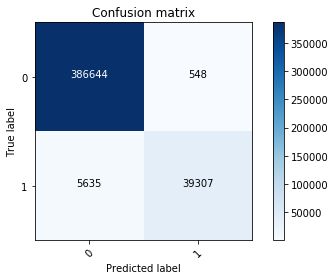

In [20]:
cnf_matrix = confusion_matrix(y_test, predictions_XG_boost,labels=[0,1])
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=[0,1],
                      title='Confusion matrix')

In [21]:
print(classification_report(y_test,predictions_XG_boost))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99    387192
           1       0.99      0.87      0.93     44942

    accuracy                           0.99    432134
   macro avg       0.99      0.94      0.96    432134
weighted avg       0.99      0.99      0.99    432134



XG_boost is doing the bet job and precision score is 95% and for all the labels model precision is above 84% 
but trouble in recall upon label-2 & 3

### Logistic Regression for binary class classification upon normal and attack traffic

Hyper-perameter tuning

In [ ]:
from sklearn.linear_model import SGDClassifier
SGDClassifier(loss='log')

SGDClassifier(loss='log')

In [33]:
clf=SGDClassifier(penalty='l2')

prams={'alpha':[0.000001,0.00001,0.0001,0.00000001],'eta0':[0.1,0.01,0.001,0.0001],"tol":[0.001,0.0001,0.01,0.00001]} 



LR= RandomizedSearchCV(clf, param_distributions=prams,n_iter=4,
                                   cv=3,scoring='recall_macro',random_state=25,verbose=2,n_jobs=-1)

LR.fit(X_tr,y_train)



Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  12 | elapsed:  3.0min remaining:  6.1min
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed: 18.0min finished


RandomizedSearchCV(cv=3, estimator=SGDClassifier(), n_iter=4, n_jobs=-1,
                   param_distributions={'alpha': [1e-06, 1e-05, 0.0001, 1e-08],
                                        'eta0': [0.1, 0.01, 0.001, 0.0001],
                                        'tol': [0.001, 0.0001, 0.01, 1e-05]},
                   random_state=25, scoring='recall_macro', verbose=2)

In [34]:
LR.best_params_, LR.best_score_

({'tol': 0.001, 'eta0': 0.1, 'alpha': 1e-06}, 0.9356949757229129)

In [22]:

LR=SGDClassifier(eta0=0.1, alpha=0.0000001,tol=0.001, loss='log', random_state=25,  
                  verbose=2, learning_rate='constant',n_jobs=-1)

LR.fit(X_tr,y_train)
#predictions_LR = LR.predict(X_te)

-- Epoch 1
Norm: 59.24, NNZs: 26, Bias: 12.019466, T: 3097534, Avg. loss: 1.838159
Total training time: 0.85 seconds.
-- Epoch 2
Norm: 74.40, NNZs: 26, Bias: 14.025267, T: 6195068, Avg. loss: 1.834692
Total training time: 1.72 seconds.
-- Epoch 3
Norm: 85.41, NNZs: 26, Bias: 16.041050, T: 9292602, Avg. loss: 1.832760
Total training time: 2.59 seconds.
-- Epoch 4
Norm: 93.90, NNZs: 26, Bias: 19.288207, T: 12390136, Avg. loss: 1.830231
Total training time: 3.45 seconds.
-- Epoch 5
Norm: 100.59, NNZs: 26, Bias: 20.043521, T: 15487670, Avg. loss: 1.830054
Total training time: 4.32 seconds.
-- Epoch 6
Norm: 106.30, NNZs: 26, Bias: 19.836997, T: 18585204, Avg. loss: 1.833419
Total training time: 5.20 seconds.
-- Epoch 7
Norm: 109.67, NNZs: 26, Bias: 21.251993, T: 21682738, Avg. loss: 1.832903
Total training time: 6.05 seconds.
-- Epoch 8
Norm: 111.52, NNZs: 26, Bias: 20.760672, T: 24780272, Avg. loss: 1.832873
Total training time: 6.88 seconds.
-- Epoch 9
Norm: 113.55, NNZs: 26, Bias: 22.835

SGDClassifier(alpha=1e-07, eta0=0.1, learning_rate='constant', loss='log',
              n_jobs=-1, random_state=25, verbose=2)

In [23]:
#X_train_predictions_LR = LR.predict(X_tr)
predictions_LR = LR.predict(X_test)

Confusion matrix, without normalization
[[385622   1570]
 [  5630  39312]]


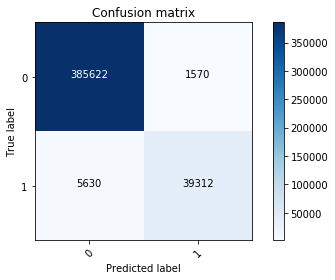

In [24]:
cnf_matrix = confusion_matrix(y_test, predictions_LR,labels=[0,1])
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=[0,1],
                      title='Confusion matrix')

In [25]:
print(classification_report(y_test,predictions_LR))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99    387192
           1       0.96      0.87      0.92     44942

    accuracy                           0.98    432134
   macro avg       0.97      0.94      0.95    432134
weighted avg       0.98      0.98      0.98    432134



LR is also doing a good job having high precision and recall for label-2 & 3 also improved compare to previous models

### GaussianNB for binary class classification

In [26]:

NB=GaussianNB(var_smoothing=1e-18)
NB.fit(X_tr,y_train)
predictions_NB = NB.predict(X_test)


Confusion matrix, without normalization
[[384765   2427]
 [  5862  39080]]


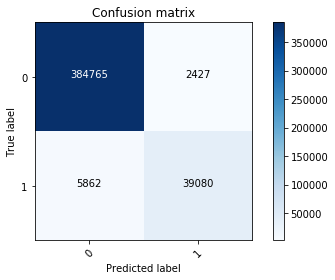

In [27]:
cnf_matrix = confusion_matrix(y_test, predictions_NB,labels=[0,1])
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=[0,1],
                      title='Confusion matrix')

In [28]:
print(classification_report(y_test,predictions_NB))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99    387192
           1       0.94      0.87      0.90     44942

    accuracy                           0.98    432134
   macro avg       0.96      0.93      0.95    432134
weighted avg       0.98      0.98      0.98    432134



GaussianNB is not doing a good job macro precission is around only 48% and labe-3 not been detected even once

### Random Forest for binary class classification

Hyper-perameter tunnig

In [59]:
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
from scipy.stats import uniform

param_dist = {"n_estimators":[30,40,50,60],
              "max_depth": [70,80,90,100],
              "min_samples_split": [120,125,130,135],
              "min_samples_leaf":[1,2,4,8]}

clf = RandomForestClassifier(random_state=25,n_jobs=-1)

rf_random = RandomizedSearchCV(clf, param_distributions=param_dist,
                                   n_iter=5,cv=3,scoring='f1_macro',random_state=25,verbose=2)

rf_random.fit(X_tr,y_train)
print('mean test scores',rf_random.cv_results_['mean_test_score'])
#print('mean train scores',rf_random.cv_results_['mean_train_score'])


Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] n_estimators=50, min_samples_split=120, min_samples_leaf=4, max_depth=90 
[CV]  n_estimators=50, min_samples_split=120, min_samples_leaf=4, max_depth=90, total= 3.2min
[CV] n_estimators=50, min_samples_split=120, min_samples_leaf=4, max_depth=90 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.2min remaining:    0.0s


[CV]  n_estimators=50, min_samples_split=120, min_samples_leaf=4, max_depth=90, total= 2.8min
[CV] n_estimators=50, min_samples_split=120, min_samples_leaf=4, max_depth=90 
[CV]  n_estimators=50, min_samples_split=120, min_samples_leaf=4, max_depth=90, total= 2.8min
[CV] n_estimators=40, min_samples_split=120, min_samples_leaf=4, max_depth=90 
[CV]  n_estimators=40, min_samples_split=120, min_samples_leaf=4, max_depth=90, total= 2.4min
[CV] n_estimators=40, min_samples_split=120, min_samples_leaf=4, max_depth=90 
[CV]  n_estimators=40, min_samples_split=120, min_samples_leaf=4, max_depth=90, total= 2.3min
[CV] n_estimators=40, min_samples_split=120, min_samples_leaf=4, max_depth=90 
[CV]  n_estimators=40, min_samples_split=120, min_samples_leaf=4, max_depth=90, total= 2.4min
[CV] n_estimators=50, min_samples_split=120, min_samples_leaf=1, max_depth=80 
[CV]  n_estimators=50, min_samples_split=120, min_samples_leaf=1, max_depth=80, total= 3.1min
[CV] n_estimators=50, min_samples_split=1

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed: 36.6min finished


mean test scores [0.94 0.94 0.94 0.94 0.94]


In [61]:
print(rf_random.best_estimator_)

RandomForestClassifier(max_depth=80, min_samples_split=120, n_estimators=50,
                       n_jobs=-1, random_state=25)


In [85]:
RF_clf = RandomForestClassifier(n_estimators=50,
  min_samples_split=100,
  min_samples_leaf=2,
  max_depth=80,verbose=2,n_jobs=-1)

RF_clf.fit(X_tr,y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50building tree 13 of 50

building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50building tree 28 of 50

building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  2.9min


building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 of 50
building tree 47 of 50
building tree 48 of 50
building tree 49 of 50
building tree 50 of 50


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  5.1min finished


RandomForestClassifier(max_depth=80, min_samples_leaf=2, min_samples_split=100,
                       n_estimators=50, n_jobs=-1, verbose=2)

In [86]:
y_train_pred = RF_clf.predict(X_tr)
y_test_pred = RF_clf.predict(X_test)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    5.9s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:   10.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    1.1s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    1.9s finished


In [87]:
print('Train precision score',precision_score(y_train,y_train_pred, average='macro'))
print('Test precision score',precision_score(y_test,y_test_pred, average='macro'))

Train precision score 0.9492034623806938
Test precision score 0.9863598634629426


In [19]:
print('Train precision score',precision_score(y_train,y_train_pred, average='micro'))
print('Test precision score',precision_score(y_test,y_test_pred, average='micro'))

Train precision score 0.942895219229232
Test precision score 0.985590117880102


Confusion matrix, without normalization
[[386672    520]
 [  5707  39235]]


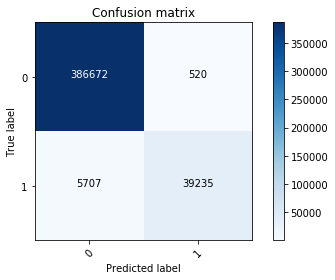

In [22]:
cnf_matrix = confusion_matrix(y_test, y_test_pred,labels=[0,1])
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=[0,1],
                      title='Confusion matrix')

In [23]:
print(classification_report(y_test,y_test_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99    387192
           1       0.99      0.87      0.93     44942

    accuracy                           0.99    432134
   macro avg       0.99      0.94      0.96    432134
weighted avg       0.99      0.99      0.99    432134



Random Forest is having macro avg precission of 95% precission score good for all the labels 
however the Recall for label-2 and 3 is low around 30-32%

In [88]:
# Save the Modle to file in the current working directory

Best_RF_Mode_1 = "Pickle_RL_Model_1.pkl"  

with open(Best_RF_Mode_1, 'wb') as file:  
    pickle.dump(RF_clf, file)

In [90]:
loaded_model = pickle.load(open(Best_RF_Mode_1, 'rb'))
result = loaded_model.score(X_test, y_test)
print(result)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    1.0s


0.9858886363951922


[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    1.8s finished


### Custom Model on data with SMOTE

In [559]:
import random
from tqdm import tqdm
def random_50(x_train):
    D1=random.sample(range(0, len(x_train)), int(0.5*len(x_train)))
    D2 = list(set(list(range(1, len(x_train)))) - set(D1))
    return D1,D2

In [560]:
first_indices,second_indices=random_50(X_tr.values)# getting two idices for D1 and D2

In [562]:
D1_y_train=y_train[first_indices]
D2_y_train=y_train[second_indices]

In [567]:
D1_X_train=X_tr.values[first_indices]
D2_X_train=X_tr.values[second_indices]

In [568]:
D1_X_train.shape,D2_X_train.shape

((1548767, 26), (1548767, 26))

In [569]:
def chunk(l,n):        # function divide the X-train by number of folds into chunks
    for i in range (1,len(l),n):
        yield l[i:i+n]
    
from tqdm import tqdm    
def Custom_model(D1_x_train,D1_y_train,classifier,D2_x_train,X_test,folds):
        D_meta=[]
        D_test_meta =[]
        c=[i for i in range(0,(len(D1_x_train)))]        #list of total indices
        b=math.ceil(len(D1_x_train)/folds)               #definig the range of folded chunks
        
                      
        for j in tqdm(range(0, folds)):
            
            test_indices =list(chunk(c,b))[j]        #taking divided chunks of indices from list in evry loop of folds
            train_indices  = list(set(list(range(1, len(D1_x_train)))) - set(test_indices))  #take rest of the indieses as traing for each loop
            
          
            D1_x_train1 = D1_x_train[train_indices]
            D1_y_train1 = D1_y_train[train_indices]
            
            classifier.fit(D1_x_train1,D1_y_train1)

            Y_predicted = classifier.predict(D2_x_train)
            test_set1= classifier.predict(X_test)
        
            D_meta.append(Y_predicted)
            D_test_meta .append(test_set1)
        
        D_meta=np.array(D_meta)  
        D_test_meta=np.array(D_test_meta)
        return D_meta.reshape(D_meta.shape[1],D_meta.shape[0]),D_test_meta.reshape(D_test_meta.shape[1],D_test_meta.shape[0])

In [570]:
DT = DecisionTreeClassifier()
k = 15

D_meta,D_test_meta = Custom_model(D1_X_train,D1_y_train, DT, D2_X_train,X_test,k)

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:25<00:00, 28.53s/it]


In [571]:
meta_model=XGBClassifier(max_depth=10,n_estimators=100,learning_rate=0.01,verbose=1,n_jobs=-1)

meta_model =meta_model.fit(D_meta,D2_y_train)

[05:56:01] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




In [572]:
pred_final=meta_model.predict(D_test_meta)

In [573]:

print('Test precision score macro',precision_score(y_test,pred_final, average='macro'))
print('Test precision score micro',precision_score(y_test,pred_final, average='micro'))

Test precision score macro 0.49859295199338816
Test precision score micro 0.8528488848366479


Confusion matrix, without normalization
[[366175  21017]
 [ 42572   2370]]


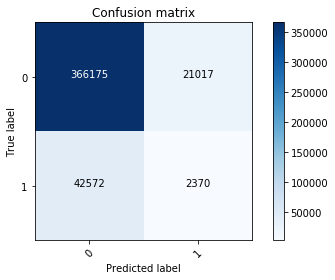

In [574]:
cnf_matrix = confusion_matrix(y_test, pred_final,labels=[0,1])
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=[0,1],
                      title='Confusion matrix')

In [575]:
print(classification_report(y_test,pred_final))

              precision    recall  f1-score   support

           0       0.90      0.95      0.92    387192
           1       0.10      0.05      0.07     44942

    accuracy                           0.85    432134
   macro avg       0.50      0.50      0.49    432134
weighted avg       0.81      0.85      0.83    432134



We can see the most of the models are having good results having all scores above 90 % for binary classification

### Fit model only on the remaining 4 types of Attack 

In [334]:
df.head()

,SRC_ADD,DES_ADD,PKT_ID,FROM_NODE,TO_NODE,PKT_TYPE,PKT_SIZE,FLAGS,FID,SEQ_NUMBER,...,PKT_DELAY,PKT_SEND_TIME,PKT_RESEVED_TIME,FIRST_PKT_SENT,LAST_PKT_RESEVED,PKT_CLASS,new_class,PKT_TYPE_encode,NODE_NAME_FROM_encode,NODE_NAME_TO_encode
0,3.00,24.30,389693.0,21.0,23.0,tcp,1540.0,0,4.0,11339.0,...,0.0,35.519662,35.550032,1.000000,50.021920,0,0,3,44,42
1,15.00,24.15,201196.0,23.0,24.0,tcp,1540.0,0,16.0,6274.0,...,0.0,20.156478,20.186848,1.000000,50.030211,0,0,3,42,43
2,24.15,15.00,61905.0,23.0,22.0,ack,55.0,0,16.0,1930.0,...,0.0,7.039952,7.069962,1.030045,50.060221,1,1,0,42,45
3,24.90,9.00,443135.0,23.0,21.0,ack,55.0,0,10.0,12670.0,...,0.0,39.617967,39.647976,1.030058,50.060098,0,0,0,42,44
4,24.80,8.00,157335.0,23.0,21.0,ack,55.0,0,9.0,4901.0,...,0.0,16.029803,16.059813,1.030054,50.061864,0,0,0,42,44


In [335]:
Attack_df=df[df['PKT_CLASS']!=0]  # removing all the normal traffic data and preparing a datset with only the attack traffic

In [336]:
Attack_df.shape

(224709, 32)

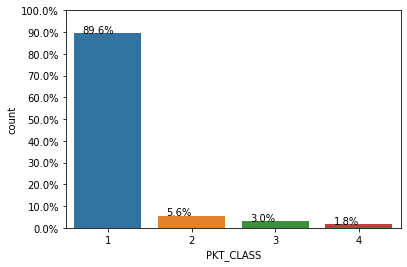

In [337]:

total = len(Attack_df)*1.
ax=sns.countplot(x="PKT_CLASS", data=Attack_df)
for p in ax.patches:
        ax.annotate('{:.1f}%'.format(100*p.get_height()/total), (p.get_x()+0.1, p.get_height()+5))

#put 11 ticks (therefore 10 steps), from 0 to the total number of rows in the dataframe
ax.yaxis.set_ticks(np.linspace(0, total, 11))

#adjust the ticklabel to the desired format, without changing the position of the ticks. 
ax.set_yticklabels(map('{:.1f}%'.format, 100*ax.yaxis.get_majorticklocs()/total))
plt.show()

In [338]:
Attack_df['PKT_CLASS'].value_counts()

1    201344
2     12590
3      6665
4      4110
Name: PKT_CLASS, dtype: int64

In [451]:
y = Attack_df['PKT_CLASS'].values  # separated the class lable in Y
X = Attack_df.drop(['PKT_CLASS','new_class','PKT_TYPE','NODE_NAME_FROM','NODE_NAME_TO','FLAGS'], axis=1)   # combined all the features into X
X.head(1)

,SRC_ADD,DES_ADD,PKT_ID,FROM_NODE,TO_NODE,PKT_SIZE,FID,SEQ_NUMBER,NUMBER_OF_PKT,NUMBER_OF_BYTE,...,PKT_AVG_SIZE,UTILIZATION,PKT_DELAY,PKT_SEND_TIME,PKT_RESEVED_TIME,FIRST_PKT_SENT,LAST_PKT_RESEVED,PKT_TYPE_encode,NODE_NAME_FROM_encode,NODE_NAME_TO_encode
2,24.15,15.0,61905.0,23.0,22.0,55.0,16.0,1930.0,16092.0,885060.0,...,55.0,0.008441,0.0,7.039952,7.069962,1.030045,50.060221,0,42,45


In [452]:
# train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20,shuffle=True,stratify=y )

In [453]:
def normalizer(a,b):
    
    from sklearn.preprocessing import StandardScaler
    normalizer_= StandardScaler()
    normalizer_.fit(a.reshape(-1,1))
    X_train = normalizer_.transform(a.reshape(-1,1))

    X_test= normalizer_.transform(b.reshape(-1,1))
    return X_train,X_test

In [454]:
# X_train['SRC_ADD'],X_test['SRC_ADD']=normalizer(X_train['SRC_ADD'].values,X_test['SRC_ADD'].values)
X_train['DES_ADD'],X_test['DES_ADD']=normalizer(X_train['DES_ADD'].values,X_test['DES_ADD'].values)
X_train['PKT_ID'],X_test['PKT_ID']=normalizer(X_train['PKT_ID'].values,X_test['PKT_ID'].values)

X_train['PKT_SIZE'],X_test['PKT_SIZE']=normalizer(X_train['PKT_SIZE'].values,X_test['PKT_SIZE'].values)
X_train['FID'],X_test['FID']=normalizer(X_train['FID'].values,X_test['FID'].values)
X_train['SEQ_NUMBER'],X_test['SEQ_NUMBER']=normalizer(X_train['SEQ_NUMBER'].values,X_test['SEQ_NUMBER'].values)
X_train['NUMBER_OF_PKT'],X_test['NUMBER_OF_PKT']=normalizer(X_train['NUMBER_OF_PKT'].values,X_test['NUMBER_OF_PKT'].values)
X_train['NUMBER_OF_BYTE'],X_test['NUMBER_OF_BYTE']=normalizer(X_train['NUMBER_OF_BYTE'].values,X_test['NUMBER_OF_BYTE'].values)

X_train['PKT_IN'],X_test['PKT_IN']=normalizer(X_train['PKT_IN'].values,X_test['PKT_IN'].values)
X_train['PKT_R'],X_test['PKT_R']=normalizer(X_train['PKT_R'].values,X_test['PKT_R'].values)
X_train['PKT_OUT'],X_test['PKT_OUT']=normalizer(X_train['PKT_OUT'].values,X_test['PKT_OUT'].values)
X_train['PKT_RATE'],X_test['PKT_RATE']=normalizer(X_train['PKT_RATE'].values,X_test['PKT_RATE'].values)
X_train['BYTE_RATE'],X_test['BYTE_RATE']=normalizer(X_train['BYTE_RATE'].values,X_test['BYTE_RATE'].values)
X_train['PKT_AVG_SIZE'],X_test['PKT_AVG_SIZE']=normalizer(X_train['PKT_AVG_SIZE'].values,X_test['PKT_AVG_SIZE'].values)
X_train['UTILIZATION'],X_test['UTILIZATION']=normalizer(X_train['UTILIZATION'].values,X_test['UTILIZATION'].values)
X_train['PKT_DELAY'],X_test['PKT_DELAY']=normalizer(X_train['PKT_DELAY'].values,X_test['PKT_DELAY'].values)
X_train['PKT_SEND_TIME'],X_test['PKT_SEND_TIME']=normalizer(X_train['PKT_SEND_TIME'].values,X_test['PKT_SEND_TIME'].values)
X_train['PKT_RESEVED_TIME'],X_test['PKT_RESEVED_TIME']=normalizer(X_train['PKT_RESEVED_TIME'].values,X_test['PKT_RESEVED_TIME'].values)
X_train['FIRST_PKT_SENT'],X_test['FIRST_PKT_SENT']=normalizer(X_train['FIRST_PKT_SENT'].values,X_test['FIRST_PKT_SENT'].values)
X_train['LAST_PKT_RESEVED'],X_test['LAST_PKT_RESEVED']=normalizer(X_train['LAST_PKT_RESEVED'].values,X_test['LAST_PKT_RESEVED'].values)
X_train['PKT_DELAY_NODE'],X_test['PKT_DELAY_NODE']=normalizer(X_train['PKT_DELAY_NODE'].values,X_test['PKT_DELAY_NODE'].values)
X_train['FROM_NODE'],X_test['FROM_NODE']=normalizer(X_train['FROM_NODE'].values,X_test['FROM_NODE'].values)
X_train['TO_NODE'],X_test['TO_NODE']=normalizer(X_train['TO_NODE'].values,X_test['TO_NODE'].values)
X_train['NODE_NAME_FROM_encode'],X_test['NODE_NAME_FROM_encode']=normalizer(X_train['NODE_NAME_FROM_encode'].values,X_test['NODE_NAME_FROM_encode'].values)
X_train['NODE_NAME_TO_encode'],X_test['NODE_NAME_TO_encode']=normalizer(X_train['NODE_NAME_TO_encode'].values,X_test['NODE_NAME_TO_encode'].values)
X_train['PKT_TYPE_encode'],X_test['PKT_TYPE_encode']=normalizer(X_train['PKT_TYPE_encode'].values,X_test['PKT_TYPE_encode'].values)


[8.83e-03 9.84e-03 4.81e-02 3.35e-03 4.23e-03 4.83e-02 2.46e-05 5.00e-02
 3.40e-02 6.79e-02 3.18e-02 4.08e-02 4.19e-02 4.20e-02 5.89e-03 1.27e-01
 4.04e-02 5.42e-02 2.87e-02 3.07e-02 4.07e-02 4.27e-02 2.35e-02 6.94e-02
 9.99e-02 2.99e-03 2.95e-03]


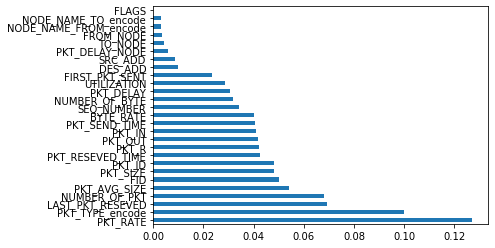

In [272]:
#ref#https://towardsdatascience.com/feature-selection-techniques-in-machine-learning-with-python-f24e7da3f36e#:~:text=Feature%20Selection%20is%20the%20process,learn%20based%20on%20irrelevant%20features.

from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
model = ExtraTreesClassifier()
model.fit(X,y)
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(27).plot(kind='barh')
plt.show()

### SMOTE on dataset with attack

In [380]:
%time
from imblearn.over_sampling import SMOTE
oversample = SMOTE(k_neighbors=7)
X_tr, y_train = oversample.fit_resample(X_train, y_train)

Wall time: 0 ns


In [458]:
X_train.shape,X_train.shape,X.shape,y.shape

((179767, 116), (644300, 26), (224709, 26), (224709,))

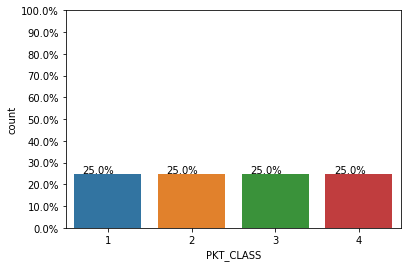

In [305]:

total = len(X)*1.
ax=sns.countplot(x="PKT_CLASS", data=X)
for p in ax.patches:
        ax.annotate('{:.1f}%'.format(100*p.get_height()/total), (p.get_x()+0.1, p.get_height()+5))

#put 11 ticks (therefore 10 steps), from 0 to the total number of rows in the dataframe
ax.yaxis.set_ticks(np.linspace(0, total, 11))

#adjust the ticklabel to the desired format, without changing the position of the ticks. 
ax.set_yticklabels(map('{:.1f}%'.format, 100*ax.yaxis.get_majorticklocs()/total))
plt.show()

### XGB without SMOTE

In [373]:
clf=XGBClassifier()

prams={
     'n_estimators':[10,20,50,80,100],

    'min_child_weight' : [150,200,250,300,350],
    'learning_rate':[0.5, 0.01, 0.25, 0.1],
        'max_depth':[5,10,20,40,60],
    'subsample':[0.75,0.80,0.85,0.90,1,2],
    'gamma' : [ 0.0,0.1, 0.2,0.3,0.4,0.9,1],
     }


XG_boost= RandomizedSearchCV(clf, param_distributions=prams,
                                   n_iter=4,cv=3,scoring='recall_macro',random_state=25,verbose=2,n_jobs=-1)

XG_boost.fit(X_train,y_train)
XG_boost.best_params_, XG_boost.best_score_


Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  12 | elapsed:  4.6min remaining:  9.3min
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:  7.6min finished


({'subsample': 0.75,
  'n_estimators': 80,
  'min_child_weight': 150,
  'max_depth': 60,
  'learning_rate': 0.5,
  'gamma': 0.2},
 0.808642588608306)

In [374]:
XG_boost=XGBClassifier(gamma=0.2,max_depth=60,n_estimators=80,learning_rate=0.5,min_child_weight=150,subsample=.75,verbose=1,n_jobs=-1)

XG_boost.fit(X_train,y_train)

[01:16:12] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.2, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.5, max_delta_step=0, max_depth=60,
              min_child_weight=150, missing=nan, monotone_constraints='()',
              n_estimators=80, n_jobs=-1, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=0.75,
              tree_method='exact', validate_parameters=1, verbose=1,
              verbosity=None)

In [375]:
y_train_pred = XG_boost.predict(X_train)
y_test_pred = XG_boost.predict(X_test)

Confusion matrix, without normalization
[[40191    78     0     0]
 [ 1535   897    75    11]
 [   67     4  1262     0]
 [    0     0    39   783]]


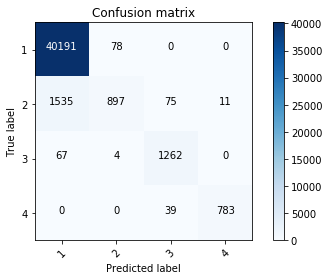

In [376]:
cnf_matrix = confusion_matrix(y_test, y_test_pred,labels=[1,2,3,4])
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=[1,2,3,4],
                      title='Confusion matrix')

Confusion matrix, without normalization
[[160935    140      0      0]
 [  6051   3713    275     33]
 [   265     14   5053      0]
 [     0      0    181   3107]]


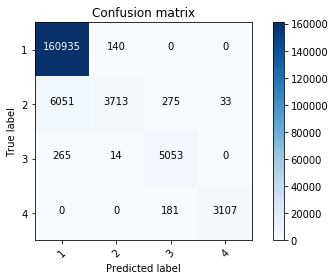

In [377]:
cnf_matrix = confusion_matrix(y_train, y_train_pred,labels=[1,2,3,4])
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=[1,2,3,4],
                      title='Confusion matrix')

In [378]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           1       0.96      1.00      0.98     40269
           2       0.92      0.36      0.51      2518
           3       0.92      0.95      0.93      1333
           4       0.99      0.95      0.97       822

    accuracy                           0.96     44942
   macro avg       0.95      0.81      0.85     44942
weighted avg       0.96      0.96      0.95     44942



In [379]:
print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

           1       0.96      1.00      0.98    161075
           2       0.96      0.37      0.53     10072
           3       0.92      0.95      0.93      5332
           4       0.99      0.94      0.97      3288

    accuracy                           0.96    179767
   macro avg       0.96      0.82      0.85    179767
weighted avg       0.96      0.96      0.95    179767



## XGB with SMOTE

In [381]:

clf=XGBClassifier()

prams={
     'n_estimators':[10,20,50,80,100],

    'min_child_weight' : [150,200,250,300,350],
    'learning_rate':[0.5, 0.01, 0.25, 0.1],
        'max_depth':[5,10,20,40,60],
    'subsample':[0.75,0.80,0.85,0.90,1,2],
    'gamma' : [ 0.0,0.1, 0.2,0.3,0.4,0.9,1],
     }


XG_boost= RandomizedSearchCV(clf, param_distributions=prams,
                                   n_iter=4,cv=3,scoring='precision_macro',random_state=25,verbose=2,n_jobs=-1)

XG_boost.fit(X_tr,y_train)
XG_boost.best_params_, XG_boost.best_score_


Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  12 | elapsed: 61.1min remaining: 122.3min
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed: 90.0min finished


({'subsample': 0.75,
  'n_estimators': 80,
  'min_child_weight': 150,
  'max_depth': 60,
  'learning_rate': 0.5,
  'gamma': 0.2},
 0.9541274462834052)

In [383]:
XG_boost=XGBClassifier(gamma=0.2,max_depth=60,n_estimators=80,learning_rate=0.5,min_child_weight=150,subsample=.75,verbose=1,n_jobs=-1)

XG_boost.fit(X_tr,y_train)

[03:05:51] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.2, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.5, max_delta_step=0, max_depth=60,
              min_child_weight=150, missing=nan, monotone_constraints='()',
              n_estimators=80, n_jobs=-1, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=0.75,
              tree_method='exact', validate_parameters=1, verbose=1,
              verbosity=None)

In [387]:
y_train_pred = XG_boost.predict(X_tr)
y_test_pred = XG_boost.predict(X_test)

Confusion matrix, without normalization
[[36901  3359     9     0]
 [  189  2241    77    11]
 [   11    60  1254     8]
 [    0     1    37   784]]


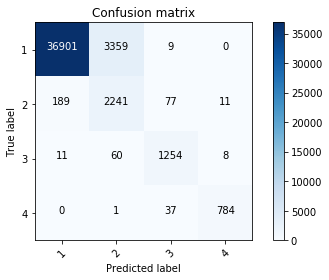

In [388]:
cnf_matrix = confusion_matrix(y_test, y_test_pred,labels=[1,2,3,4])
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=[1,2,3,4],
                      title='Confusion matrix')

Confusion matrix, without normalization
[[147984  13045     46      0]
 [   537 155968   4198    372]
 [   154   2258 158490    173]
 [     0     38   7088 153949]]


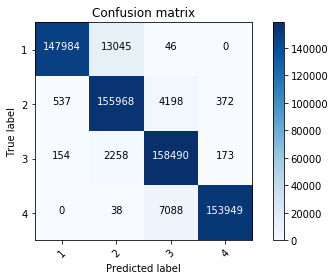

In [389]:
cnf_matrix = confusion_matrix(y_train, y_train_pred,labels=[1,2,3,4])
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=[1,2,3,4],
                      title='Confusion matrix')

In [390]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           1       0.99      0.92      0.95     40269
           2       0.40      0.89      0.55      2518
           3       0.91      0.94      0.93      1333
           4       0.98      0.95      0.96       822

    accuracy                           0.92     44942
   macro avg       0.82      0.93      0.85     44942
weighted avg       0.96      0.92      0.93     44942



In [391]:
print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

           1       1.00      0.92      0.96    161075
           2       0.91      0.97      0.94    161075
           3       0.93      0.98      0.96    161075
           4       1.00      0.96      0.98    161075

    accuracy                           0.96    644300
   macro avg       0.96      0.96      0.96    644300
weighted avg       0.96      0.96      0.96    644300



### RF with SMOTE

In [491]:


param_dist = {"n_estimators":[30,50,80,100,500,1000,2000],
              "max_depth": [70,80,90,100,200],
              "min_samples_split": [5,10,20,50,80,100],
              "min_samples_leaf":[1,4,16,24]}

clf = RandomForestClassifier(random_state=25,n_jobs=-1)

rf_random = RandomizedSearchCV(clf, param_distributions=param_dist,
                                   n_iter=5,cv=3,scoring='precision_macro',random_state=25,verbose=2)

rf_random.fit(X_train,y_train)
print('mean test scores',rf_random.cv_results_['mean_test_score'])
#print('mean train scores',rf_random.cv_results_['mean_train_score'])
rf_random.best_params_, rf_random.best_score_

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] n_estimators=2000, min_samples_split=5, min_samples_leaf=24, max_depth=70 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  n_estimators=2000, min_samples_split=5, min_samples_leaf=24, max_depth=70, total= 9.6min
[CV] n_estimators=2000, min_samples_split=5, min_samples_leaf=24, max_depth=70 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  9.6min remaining:    0.0s


[CV]  n_estimators=2000, min_samples_split=5, min_samples_leaf=24, max_depth=70, total= 9.8min
[CV] n_estimators=2000, min_samples_split=5, min_samples_leaf=24, max_depth=70 
[CV]  n_estimators=2000, min_samples_split=5, min_samples_leaf=24, max_depth=70, total=10.5min
[CV] n_estimators=100, min_samples_split=50, min_samples_leaf=24, max_depth=80 
[CV]  n_estimators=100, min_samples_split=50, min_samples_leaf=24, max_depth=80, total=  32.7s
[CV] n_estimators=100, min_samples_split=50, min_samples_leaf=24, max_depth=80 
[CV]  n_estimators=100, min_samples_split=50, min_samples_leaf=24, max_depth=80, total=  33.2s
[CV] n_estimators=100, min_samples_split=50, min_samples_leaf=24, max_depth=80 
[CV]  n_estimators=100, min_samples_split=50, min_samples_leaf=24, max_depth=80, total=  32.6s
[CV] n_estimators=1000, min_samples_split=10, min_samples_leaf=24, max_depth=90 
[CV]  n_estimators=1000, min_samples_split=10, min_samples_leaf=24, max_depth=90, total= 5.7min
[CV] n_estimators=1000, min_

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed: 52.5min finished


mean test scores [0.95 0.95 0.95 0.95 0.95]


({'n_estimators': 100,
  'min_samples_split': 20,
  'min_samples_leaf': 24,
  'max_depth': 70},
 0.9518272199231813)

In [88]:
rf_random.best_params_, rf_random.best_score_

({'n_estimators': 80,
  'min_samples_split': 20,
  'min_samples_leaf': 1,
  'max_depth': 80},
 0.8730977435131043)

In [53]:
rf_random.best_params_, rf_random.best_score_

({'min_samples_split': 20}, 0.961941481737282)

In [401]:
RF_clf=RandomForestClassifier(n_estimators=100,
  min_samples_split=20,
  min_samples_leaf=24,
  max_depth=70,verbose=2,n_jobs=-1)

RF_clf.fit(X_tr,y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   15.4s


building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   49.3s finished


RandomForestClassifier(max_depth=70, min_samples_leaf=24, min_samples_split=20,
                       n_jobs=-1, verbose=2)

In [402]:
y_train_pred = RF_clf.predict(X_tr)
y_test_pred = RF_clf.predict(X_test)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    2.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished


Confusion matrix, without normalization
[[36484  3755    30     0]
 [   54  2374    79    11]
 [    4    67  1253     9]
 [    0     0    39   783]]


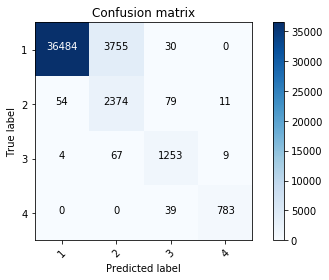

In [403]:
cnf_matrix = confusion_matrix(y_test, y_test_pred,labels=[1,2,3,4])
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=[1,2,3,4],
                      title='Confusion matrix')

Confusion matrix, without normalization
[[145765  15203    107      0]
 [   114 156114   4549    298]
 [    50   3558 157386     81]
 [     0     10   7934 153131]]


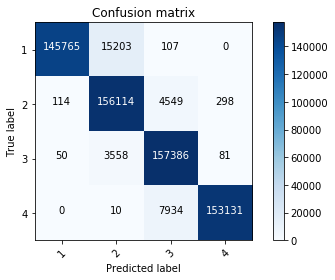

In [404]:
cnf_matrix = confusion_matrix(y_train, y_train_pred,labels=[1,2,3,4])
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=[1,2,3,4],
                      title='Confusion matrix')

In [407]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           1       1.00      0.91      0.95     40269
           2       0.38      0.94      0.54      2518
           3       0.89      0.94      0.92      1333
           4       0.98      0.95      0.96       822

    accuracy                           0.91     44942
   macro avg       0.81      0.94      0.84     44942
weighted avg       0.96      0.91      0.93     44942



In [408]:
print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

           1       1.00      0.90      0.95    161075
           2       0.89      0.97      0.93    161075
           3       0.93      0.98      0.95    161075
           4       1.00      0.95      0.97    161075

    accuracy                           0.95    644300
   macro avg       0.95      0.95      0.95    644300
weighted avg       0.95      0.95      0.95    644300



### SGD with SMOTE

In [188]:
clf=SGDClassifier(penalty='l2')

prams={'alpha':[0.000001,0.00001,0.0001,0.00000001],'eta0':[0.1,0.01,0.001,0.0001],"tol":[0.001,0.0001,0.01,0.00001]} 



LR= RandomizedSearchCV(clf, param_distributions=prams,n_iter=4,
                                   cv=3,scoring='precision_macro',random_state=25,verbose=2,n_jobs=-1)

LR.fit(X_tr,y_train)


Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  12 | elapsed:  3.9min remaining:  7.7min
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:  9.7min finished


RandomizedSearchCV(cv=3, estimator=SGDClassifier(), n_iter=4, n_jobs=-1,
                   param_distributions={'alpha': [1e-06, 1e-05, 0.0001, 1e-08],
                                        'eta0': [0.1, 0.01, 0.001, 0.0001],
                                        'tol': [0.001, 0.0001, 0.01, 1e-05]},
                   random_state=25, scoring='precision_macro', verbose=2)

In [189]:
LR.best_params_, LR.best_score_

({'tol': 0.001, 'eta0': 0.1, 'alpha': 1e-06}, 0.9443298634714651)

In [256]:
LR.best_params_, LR.best_score_
LR=SGDClassifier(eta0=0.0001, alpha=0.000001,tol=0.0001, loss='log', random_state=25,  
                  verbose=1, learning_rate='constant',n_jobs=-1)

LR.fit(X_tr,y_train)
#predictions_LR = LR.predict(X_te)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 3.22, NNZs: 119, Bias: -0.028161, T: 644300, Avg. loss: 0.173333
Total training time: 0.31 seconds.
-- Epoch 2Norm: 2.39, NNZs: 119, Bias: 0.014113, T: 644300, Avg. loss: 0.104412

Total training time: 0.31 seconds.
-- Epoch 2
Norm: 3.24, NNZs: 119, Bias: -0.021764, T: 644300, Avg. loss: 0.225690
Total training time: 0.32 seconds.
-- Epoch 2
Norm: 4.01, NNZs: 119, Bias: -0.028719, T: 644300, Avg. loss: 0.173742
Total training time: 0.32 seconds.
-- Epoch 2
Norm: 4.13, NNZs: 119, Bias: -0.026404, T: 1288600, Avg. loss: 0.171038
Total training time: 0.62 seconds.
-- Epoch 3
Norm: 2.87, NNZs: 119, Bias: 0.018449, T: 1288600, Avg. loss: 0.082064
Total training time: 0.62 seconds.
-- Epoch 3
Norm: 3.84, NNZs: 119, Bias: -0.034605, T: 1288600, Avg. loss: 0.130053
Total training time: 0.66 seconds.
Norm: 5.05, NNZs: 119, Bias: -0.036148, T: 1288600, Avg. loss: 0.093987
-- Epoch 3
Total training time: 0.65 seconds.
-- Epoch 3
Norm: 3.15, NNZs: 

Norm: 7.95, NNZs: 119, Bias: -0.039036, T: 12241700, Avg. loss: 0.141216
Total training time: 5.83 seconds.
-- Epoch 20
Norm: 9.18, NNZs: 119, Bias: -0.066473, T: 12241700, Avg. loss: 0.058394
Total training time: 5.90 seconds.
-- Epoch 20
Norm: 5.91, NNZs: 119, Bias: -0.056945, T: 12241700, Avg. loss: 0.119871
Total training time: 5.91 seconds.
-- Epoch 20
Norm: 8.05, NNZs: 119, Bias: -0.039350, T: 12886000, Avg. loss: 0.141009
Total training time: 6.08 seconds.
-- Epoch 21
Norm: 9.29, NNZs: 119, Bias: -0.067282, T: 12886000, Avg. loss: 0.058166
Total training time: 6.15 seconds.
-- Epoch 21
Norm: 5.96, NNZs: 119, Bias: -0.057512, T: 12886000, Avg. loss: 0.119798
Total training time: 6.18 seconds.
Convergence after 20 epochs took 6.19 seconds
Norm: 8.15, NNZs: 119, Bias: -0.039642, T: 13530300, Avg. loss: 0.140798
Total training time: 6.32 seconds.
-- Epoch 22
Norm: 9.39, NNZs: 119, Bias: -0.068028, T: 13530300, Avg. loss: 0.057951
Total training time: 6.39 seconds.
-- Epoch 22
Norm: 

[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    9.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    9.6s finished


SGDClassifier(alpha=1e-06, eta0=0.0001, learning_rate='constant', loss='log',
              n_jobs=-1, random_state=25, tol=0.0001, verbose=1)

In [257]:
y_train_pred = LR.predict(X_tr)
y_test_pred = LR.predict(X_te)

Confusion matrix, without normalization
[[36281  3987     1     0]
 [    0  2422    80    16]
 [    0    62  1271     0]
 [    0     0    54   768]]


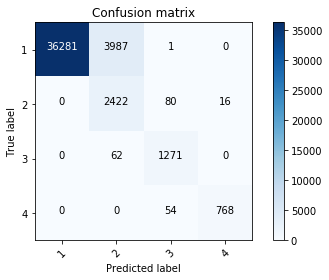

In [258]:
cnf_matrix = confusion_matrix(y_test, y_test_pred,labels=[1,2,3,4])
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=[1,2,3,4],
                      title='Confusion matrix')

Confusion matrix, without normalization
[[145063  15994     12      6]
 [     0 155639   4824    612]
 [     0   8701 152359     15]
 [     0      0   8052 153023]]


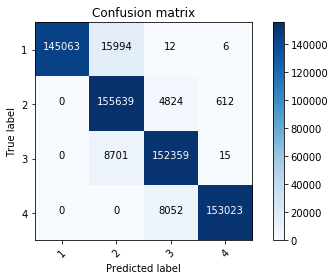

In [259]:
cnf_matrix = confusion_matrix(y_train, y_train_pred,labels=[1,2,3,4])
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=[1,2,3,4],
                      title='Confusion matrix')

In [260]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           1       1.00      0.90      0.95     40269
           2       0.37      0.96      0.54      2518
           3       0.90      0.95      0.93      1333
           4       0.98      0.93      0.96       822

    accuracy                           0.91     44942
   macro avg       0.81      0.94      0.84     44942
weighted avg       0.96      0.91      0.92     44942



In [261]:
print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

           1       1.00      0.90      0.95    161075
           2       0.86      0.97      0.91    161075
           3       0.92      0.95      0.93    161075
           4       1.00      0.95      0.97    161075

    accuracy                           0.94    644300
   macro avg       0.95      0.94      0.94    644300
weighted avg       0.95      0.94      0.94    644300



### Custom Model without SMOTE

In [455]:
import random
from tqdm import tqdm
def random_50(x_train):
    D1=random.sample(range(0, len(x_train)), int(0.5*len(x_train)))
    D2 = list(set(list(range(1, len(x_train)))) - set(D1))
    return D1,D2

In [456]:
first_indices,second_indices=random_50(X_train.values)# getting two idices for D1 and D2

In [457]:
D1_y_train=y_train[first_indices]
D2_y_train=y_train[second_indices]

In [458]:
D1_X_train=X_tr.values[first_indices]
D2_X_train=X_tr.values[second_indices]

In [459]:
D1_X_train.shape,D2_X_train.shape

((89883, 26), (89883, 26))

In [460]:
def chunk(l,n):        # function divide the X-train by number of folds into chunks
    for i in range (1,len(l),n):
        yield l[i:i+n]
    
from tqdm import tqdm    
def Custom_model(D1_x_train,D1_y_train,classifier,D2_x_train,X_test,folds):
        D_meta=[]
        D_test_meta =[]
        c=[i for i in range(0,(len(D1_x_train)))]        #list of total indices
        b=math.ceil(len(D1_x_train)/folds)               #definig the range of folded chunks
        
                      
        for j in tqdm(range(0, folds)):
            
            test_indices =list(chunk(c,b))[j]        #taking divided chunks of indices from list in evry loop of folds
            train_indices  = list(set(list(range(1, len(D1_x_train)))) - set(test_indices))  #take rest of the indieses as traing for each loop
            
          
            D1_x_train1 = D1_x_train[train_indices]
            D1_y_train1 = D1_y_train[train_indices]
            
            classifier.fit(D1_x_train1,D1_y_train1)

            Y_predicted = classifier.predict(D2_x_train)
            test_set1= classifier.predict(X_test)
        
            D_meta.append(Y_predicted)  #Storing N-pridection for meta model
            D_test_meta .append(test_set1)  #test prediction storing
        
            
        D_meta=np.array(D_meta)  
        D_test_meta=np.array(D_test_meta)
        return D_meta.reshape(D_meta.shape[1],D_meta.shape[0]),D_test_meta.reshape(D_test_meta.shape[1],D_test_meta.shape[0])

In [468]:
DT = DecisionTreeClassifier()
k = 100

D_meta,D_test_meta = Custom_model(D1_X_train,D1_y_train, DT, D2_X_train,X_test,k)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [07:54<00:00,  4.75s/it]


In [469]:

D_meta.shape,D_test_meta.shape

((89883, 100), (44942, 100))

In [470]:
meta_model=XGBClassifier(gamma=0.2,max_depth=60,n_estimators=80,learning_rate=0.5,min_child_weight=150,
                         subsample=.75,verbose=1,n_jobs=-1)

meta_model =meta_model.fit(D_meta,D2_y_train)  # creating the meta_model and fitting 

[04:18:07] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




In [472]:
pred_final=meta_model.predict(D_test_meta)

In [473]:

print('Test precision score macro',precision_score(y_test,pred_final, average='macro'))
print('Test precision score micro',precision_score(y_test,pred_final, average='micro'))

Test precision score macro 0.22400538471808107
Test precision score micro 0.8960215388723243


Confusion matrix, without normalization
[[40269     0     0     0]
 [ 2518     0     0     0]
 [ 1333     0     0     0]
 [  822     0     0     0]]


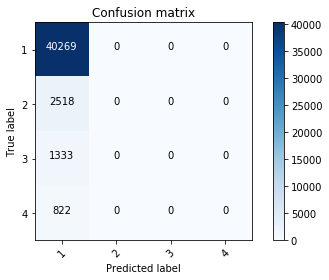

In [474]:
cnf_matrix = confusion_matrix(y_test, pred_final,labels=[1,2,3,4])
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=[1,2,3,4],
                      title='Confusion matrix')

In [475]:
print(classification_report(y_test, pred_final))

              precision    recall  f1-score   support

           1       0.90      1.00      0.95     40269
           2       0.00      0.00      0.00      2518
           3       0.00      0.00      0.00      1333
           4       0.00      0.00      0.00       822

    accuracy                           0.90     44942
   macro avg       0.22      0.25      0.24     44942
weighted avg       0.80      0.90      0.85     44942



### Tried binary classification on label-1 as class-0 and rest with class-1 with only attack dataset

In [401]:
df.head()

,SRC_ADD,DES_ADD,PKT_ID,FROM_NODE,TO_NODE,PKT_TYPE,PKT_SIZE,FLAGS,FID,SEQ_NUMBER,...,PKT_DELAY,PKT_SEND_TIME,PKT_RESEVED_TIME,FIRST_PKT_SENT,LAST_PKT_RESEVED,PKT_CLASS,new_class,PKT_TYPE_encode,NODE_NAME_FROM_encode,NODE_NAME_TO_encode
0,3.00,24.30,389693.0,21.0,23.0,tcp,1540.0,0,4.0,11339.0,...,0.0,35.519662,35.550032,1.000000,50.021920,0,0,3,44,42
1,15.00,24.15,201196.0,23.0,24.0,tcp,1540.0,0,16.0,6274.0,...,0.0,20.156478,20.186848,1.000000,50.030211,0,0,3,42,43
2,24.15,15.00,61905.0,23.0,22.0,ack,55.0,0,16.0,1930.0,...,0.0,7.039952,7.069962,1.030045,50.060221,1,1,0,42,45
3,24.90,9.00,443135.0,23.0,21.0,ack,55.0,0,10.0,12670.0,...,0.0,39.617967,39.647976,1.030058,50.060098,0,0,0,42,44
4,24.80,8.00,157335.0,23.0,21.0,ack,55.0,0,9.0,4901.0,...,0.0,16.029803,16.059813,1.030054,50.061864,0,0,0,42,44


In [412]:
Attack_df=df[df['PKT_CLASS']!=0]# getting only the attack labels


In [430]:
Attack_df.head()

,SRC_ADD,DES_ADD,PKT_ID,FROM_NODE,TO_NODE,PKT_TYPE,PKT_SIZE,FLAGS,FID,SEQ_NUMBER,...,PKT_SEND_TIME,PKT_RESEVED_TIME,FIRST_PKT_SENT,LAST_PKT_RESEVED,PKT_CLASS,new_class,PKT_TYPE_encode,NODE_NAME_FROM_encode,NODE_NAME_TO_encode,UDP_target
2,24.15,15.00,61905.0,23.0,22.0,ack,55.0,0,16.0,1930.0,...,7.039952,7.069962,1.030045,50.060221,1,1,0,42,45,0
10,9.20,24.51,33450.0,23.0,24.0,cbr,1500.0,0,30.0,1279.0,...,32.158857,32.191377,1.000000,9.960185,1,1,1,42,43,0
17,24.60,6.00,13859.0,23.0,21.0,ack,55.0,0,7.0,423.0,...,2.514346,2.544355,1.030048,50.059112,2,1,0,42,44,1
19,2.00,24.16,46094.0,2.0,21.0,ping,65535.0,0,0.0,-1.0,...,44.000000,44.056214,0.000000,9.056214,2,1,2,32,44,1
24,14.00,24.14,186408.0,22.0,23.0,tcp,1540.0,0,15.0,5812.0,...,18.764307,18.794677,1.000000,50.029965,1,1,3,45,42,0


In [565]:
df.iloc[1:2,0:26]

,SRC_ADD,DES_ADD,PKT_ID,FROM_NODE,TO_NODE,PKT_TYPE,PKT_SIZE,FLAGS,FID,SEQ_NUMBER,...,PKT_R,PKT_DELAY_NODE,PKT_RATE,BYTE_RATE,PKT_AVG_SIZE,UTILIZATION,PKT_DELAY,PKT_SEND_TIME,PKT_RESEVED_TIME,FIRST_PKT_SENT
1,15.0,24.15,201196.0,23.0,24.0,tcp,1540.0,0,16.0,6274.0,...,20.186848,0.0,328.205808,505437.0,1540.0,0.236337,0.0,20.156478,20.186848,1.0


In [431]:
def binary_attack(a):
    new_class=[]
    for i in a:    
        if i==1:
            new_class.append(0)
        else:
            new_class.append(1)
    return new_class

In [432]:
new_binary_class=binary_attack(Attack_df['PKT_CLASS'].values)

In [433]:
Attack_df['UDP_target']=new_binary_class  # new class label of label-0 for class-1 and for rest of the attack labels as label-1

In [434]:
Attack_df.head()

,SRC_ADD,DES_ADD,PKT_ID,FROM_NODE,TO_NODE,PKT_TYPE,PKT_SIZE,FLAGS,FID,SEQ_NUMBER,...,PKT_SEND_TIME,PKT_RESEVED_TIME,FIRST_PKT_SENT,LAST_PKT_RESEVED,PKT_CLASS,new_class,PKT_TYPE_encode,NODE_NAME_FROM_encode,NODE_NAME_TO_encode,UDP_target
2,24.15,15.00,61905.0,23.0,22.0,ack,55.0,0,16.0,1930.0,...,7.039952,7.069962,1.030045,50.060221,1,1,0,42,45,0
10,9.20,24.51,33450.0,23.0,24.0,cbr,1500.0,0,30.0,1279.0,...,32.158857,32.191377,1.000000,9.960185,1,1,1,42,43,0
17,24.60,6.00,13859.0,23.0,21.0,ack,55.0,0,7.0,423.0,...,2.514346,2.544355,1.030048,50.059112,2,1,0,42,44,1
19,2.00,24.16,46094.0,2.0,21.0,ping,65535.0,0,0.0,-1.0,...,44.000000,44.056214,0.000000,9.056214,2,1,2,32,44,1
24,14.00,24.14,186408.0,22.0,23.0,tcp,1540.0,0,15.0,5812.0,...,18.764307,18.794677,1.000000,50.029965,1,1,3,45,42,0


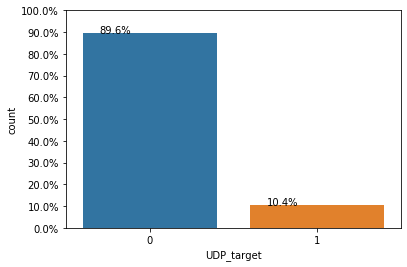

In [435]:

total = len(Attack_df)*1.
ax=sns.countplot(x="UDP_target", data=Attack_df)
for p in ax.patches:
        ax.annotate('{:.1f}%'.format(100*p.get_height()/total), (p.get_x()+0.1, p.get_height()+5))

#put 11 ticks (therefore 10 steps), from 0 to the total number of rows in the dataframe
ax.yaxis.set_ticks(np.linspace(0, total, 11))

#adjust the ticklabel to the desired format, without changing the position of the ticks. 
ax.set_yticklabels(map('{:.1f}%'.format, 100*ax.yaxis.get_majorticklocs()/total))
plt.show()

In [436]:
y = Attack_df['UDP_target'].values  # separated the class lable in Y
X = Attack_df.drop(['PKT_CLASS','new_class','PKT_TYPE','NODE_NAME_FROM','NODE_NAME_TO','FLAGS','UDP_target'], axis=1)   # combined all the features into X
X.head(1)

,SRC_ADD,DES_ADD,PKT_ID,FROM_NODE,TO_NODE,PKT_SIZE,FID,SEQ_NUMBER,NUMBER_OF_PKT,NUMBER_OF_BYTE,...,PKT_AVG_SIZE,UTILIZATION,PKT_DELAY,PKT_SEND_TIME,PKT_RESEVED_TIME,FIRST_PKT_SENT,LAST_PKT_RESEVED,PKT_TYPE_encode,NODE_NAME_FROM_encode,NODE_NAME_TO_encode
2,24.15,15.0,61905.0,23.0,22.0,55.0,16.0,1930.0,16092.0,885060.0,...,55.0,0.008441,0.0,7.039952,7.069962,1.030045,50.060221,0,42,45


In [553]:

# train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20,shuffle=True,stratify=y )

In [554]:
X_train.shape

(179767, 26)

In [555]:
def normalizer_(a):
    from sklearn.preprocessing import StandardScaler
    normalizer_= StandardScaler()
    normalizer_.fit(a.reshape(-1,1))

    return normalizer_


In [556]:
def scaler_1(x):
    scaler=[]
    for i in range(0,x.shape[1]):
        X=x[0:x.shape[0],i:i+1]
        scaler.append(normalizer_(X))
        
    return (scaler)  


In [557]:
scale_1=scaler_1(X_train.values)

In [564]:
# Save the Modle to file in the current working directory

Standardscale_1 = "Standard_scale_1.pkl"  

#with open(Standardscale_1, 'wb') as file:  
    #pickle.dump(scale_1, file)

In [561]:
def normalizer(a,b):
    
    from sklearn.preprocessing import StandardScaler
    normalizer_= StandardScaler()
    normalizer_.fit(a.reshape(-1,1))
    X_train = normalizer_.transform(a.reshape(-1,1))

    X_test= normalizer_.transform(b.reshape(-1,1))
    return X_train,X_test

In [562]:
X_train['SRC_ADD'],X_test['SRC_ADD']=normalizer(X_train['SRC_ADD'].values,X_test['SRC_ADD'].values)
X_train['DES_ADD'],X_test['DES_ADD']=normalizer(X_train['DES_ADD'].values,X_test['DES_ADD'].values)
X_train['PKT_ID'],X_test['PKT_ID']=normalizer(X_train['PKT_ID'].values,X_test['PKT_ID'].values)

X_train['PKT_SIZE'],X_test['PKT_SIZE']=normalizer(X_train['PKT_SIZE'].values,X_test['PKT_SIZE'].values)
X_train['FID'],X_test['FID']=normalizer(X_train['FID'].values,X_test['FID'].values)
X_train['SEQ_NUMBER'],X_test['SEQ_NUMBER']=normalizer(X_train['SEQ_NUMBER'].values,X_test['SEQ_NUMBER'].values)
X_train['NUMBER_OF_PKT'],X_test['NUMBER_OF_PKT']=normalizer(X_train['NUMBER_OF_PKT'].values,X_test['NUMBER_OF_PKT'].values)
X_train['NUMBER_OF_BYTE'],X_test['NUMBER_OF_BYTE']=normalizer(X_train['NUMBER_OF_BYTE'].values,X_test['NUMBER_OF_BYTE'].values)

X_train['PKT_IN'],X_test['PKT_IN']=normalizer(X_train['PKT_IN'].values,X_test['PKT_IN'].values)
X_train['PKT_R'],X_test['PKT_R']=normalizer(X_train['PKT_R'].values,X_test['PKT_R'].values)
X_train['PKT_OUT'],X_test['PKT_OUT']=normalizer(X_train['PKT_OUT'].values,X_test['PKT_OUT'].values)
X_train['PKT_RATE'],X_test['PKT_RATE']=normalizer(X_train['PKT_RATE'].values,X_test['PKT_RATE'].values)
X_train['BYTE_RATE'],X_test['BYTE_RATE']=normalizer(X_train['BYTE_RATE'].values,X_test['BYTE_RATE'].values)
X_train['PKT_AVG_SIZE'],X_test['PKT_AVG_SIZE']=normalizer(X_train['PKT_AVG_SIZE'].values,X_test['PKT_AVG_SIZE'].values)
X_train['UTILIZATION'],X_test['UTILIZATION']=normalizer(X_train['UTILIZATION'].values,X_test['UTILIZATION'].values)
X_train['PKT_DELAY'],X_test['PKT_DELAY']=normalizer(X_train['PKT_DELAY'].values,X_test['PKT_DELAY'].values)
X_train['PKT_SEND_TIME'],X_test['PKT_SEND_TIME']=normalizer(X_train['PKT_SEND_TIME'].values,X_test['PKT_SEND_TIME'].values)
X_train['PKT_RESEVED_TIME'],X_test['PKT_RESEVED_TIME']=normalizer(X_train['PKT_RESEVED_TIME'].values,X_test['PKT_RESEVED_TIME'].values)
X_train['FIRST_PKT_SENT'],X_test['FIRST_PKT_SENT']=normalizer(X_train['FIRST_PKT_SENT'].values,X_test['FIRST_PKT_SENT'].values)
X_train['LAST_PKT_RESEVED'],X_test['LAST_PKT_RESEVED']=normalizer(X_train['LAST_PKT_RESEVED'].values,X_test['LAST_PKT_RESEVED'].values)
X_train['PKT_DELAY_NODE'],X_test['PKT_DELAY_NODE']=normalizer(X_train['PKT_DELAY_NODE'].values,X_test['PKT_DELAY_NODE'].values)
X_train['FROM_NODE'],X_test['FROM_NODE']=normalizer(X_train['FROM_NODE'].values,X_test['FROM_NODE'].values)
X_train['TO_NODE'],X_test['TO_NODE']=normalizer(X_train['TO_NODE'].values,X_test['TO_NODE'].values)
X_train['NODE_NAME_FROM_encode'],X_test['NODE_NAME_FROM_encode']=normalizer(X_train['NODE_NAME_FROM_encode'].values,X_test['NODE_NAME_FROM_encode'].values)
X_train['NODE_NAME_TO_encode'],X_test['NODE_NAME_TO_encode']=normalizer(X_train['NODE_NAME_TO_encode'].values,X_test['NODE_NAME_TO_encode'].values)
X_train['PKT_TYPE_encode'],X_test['PKT_TYPE_encode']=normalizer(X_train['PKT_TYPE_encode'].values,X_test['PKT_TYPE_encode'].values)


In [524]:
%time
from imblearn.over_sampling import SMOTE
oversample = SMOTE(k_neighbors=7)
X_tr, y_train = oversample.fit_resample(X_train, y_train)

Wall time: 0 ns


### GBDT with SMOTE

In [530]:
clf=XGBClassifier()

prams={
     'n_estimators':[20,50,80,100,120,140,160,200],
    'subsample':[1,0.15,0.10,0.35,0.60],
    'min_child_weight' : [5,10,20,50,80],
    'learning_rate':[0.001, 0.75, 0.5, 0.1],
        'max_depth':[20,40,60,80,90,100]
     }


XG_boost= RandomizedSearchCV(clf, param_distributions=prams,
                                   n_iter=4,cv=3,scoring='precision_macro',random_state=25)

XG_boost.fit(X_train,y_train)
XG_boost.best_params_, XG_boost.best_score_

({'subsample': 0.6,
  'n_estimators': 80,
  'min_child_weight': 50,
  'max_depth': 60,
  'learning_rate': 0.5},
 0.9543517092114623)

In [525]:
XG_boost=XGBClassifier(subsample=0.6,max_depth=60,n_estimators=80,learning_rate=0.5,min_child_weight=50
                       ,verbose=2,n_jobs=-1)

XG_boost.fit(X_tr,y_train)

[04:55:25] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.5, max_delta_step=0, max_depth=60,
              min_child_weight=50, missing=nan, monotone_constraints='()',
              n_estimators=80, n_jobs=-1, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.6,
              tree_method='exact', validate_parameters=1, verbose=2,
              verbosity=None)

In [526]:
y_train_pred = XG_boost.predict(X_train)
y_test_pred = XG_boost.predict(X_test)

Confusion matrix, without normalization
[[37269  3000]
 [  373  4300]]


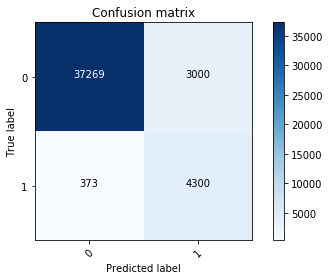

In [527]:
cnf_matrix = confusion_matrix(y_test, y_test_pred,labels=[0,1])
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=[0,1],
                      title='Confusion matrix')

In [528]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.99      0.93      0.96     40269
           1       0.59      0.92      0.72      4673

    accuracy                           0.92     44942
   macro avg       0.79      0.92      0.84     44942
weighted avg       0.95      0.92      0.93     44942



In [529]:
print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

           0       0.99      0.93      0.96    161075
           1       0.94      0.99      0.96    161075

    accuracy                           0.96    322150
   macro avg       0.96      0.96      0.96    322150
weighted avg       0.96      0.96      0.96    322150



### GBDT without SMOTE

In [328]:
clf=XGBClassifier()

prams={
     'n_estimators':[20,50,80,100,120,140,160,200],
    'subsample':[1,0.15,0.10,0.35,0.60],
    'min_child_weight' : [5,10,20,50,80],
    'learning_rate':[0.001, 0.75, 0.5, 0.1],
        'max_depth':[20,40,60,80,90,100]
     }


XG_boost= RandomizedSearchCV(clf, param_distributions=prams,
                                   n_iter=4,cv=3,scoring='recall_macro',random_state=25)

XG_boost.fit(X_train,y_train)
XG_boost.best_params_, XG_boost.best_score_

({'subsample': 0.6,
  'n_estimators': 80,
  'min_child_weight': 50,
  'max_depth': 60,
  'learning_rate': 0.5},
 0.8284891690334707)

In [329]:
XG_boost=XGBClassifier(subsample=0.6,max_depth=60,n_estimators=80,learning_rate=0.5,min_child_weight=50
                       ,verbose=2,n_jobs=-1)

XG_boost.fit(X_train,y_train)

[23:42:48] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.5, max_delta_step=0, max_depth=60,
              min_child_weight=50, missing=nan, monotone_constraints='()',
              n_estimators=80, n_jobs=-1, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.6,
              tree_method='exact', validate_parameters=1, verbose=2,
              verbosity=None)

In [330]:
y_train_pred = XG_boost.predict(X_train)
y_test_pred = XG_boost.predict(X_test)

Confusion matrix, without normalization
[[40013   256]
 [ 1538  3135]]


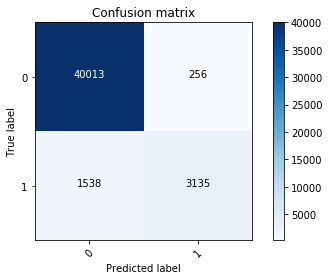

In [331]:
cnf_matrix = confusion_matrix(y_test, y_test_pred,labels=[0,1])
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=[0,1],
                      title='Confusion matrix')

In [332]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.96      0.99      0.98     40269
           1       0.92      0.67      0.78      4673

    accuracy                           0.96     44942
   macro avg       0.94      0.83      0.88     44942
weighted avg       0.96      0.96      0.96     44942



In [333]:
print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98    161075
           1       0.96      0.69      0.80     18692

    accuracy                           0.97    179767
   macro avg       0.96      0.84      0.89    179767
weighted avg       0.97      0.97      0.96    179767



### RF without SMOTE

In [109]:


param_dist = {"n_estimators":[30,50,80,100],
              "max_depth": [80,90,100,120],
              "min_samples_split": [5,10,20,50,80,100],
              "min_samples_leaf":[2,4,24,36]
             ,'max_leaf_nodes':[2,5,10,20,50,80]}

clf = RandomForestClassifier(random_state=25,n_jobs=-1)

rf_random = RandomizedSearchCV(clf, param_distributions=param_dist,
                                   n_iter=5,cv=3,scoring='recall_macro',random_state=25,verbose=2)

rf_random.fit(X_train,y_train)
print('mean test scores',rf_random.cv_results_['mean_test_score'])
#print('mean train scores',rf_random.cv_results_['mean_train_score'])
rf_random.best_params_, rf_random.best_score_

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] n_estimators=30, min_samples_split=10, min_samples_leaf=2, max_leaf_nodes=2, max_depth=100 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  n_estimators=30, min_samples_split=10, min_samples_leaf=2, max_leaf_nodes=2, max_depth=100, total=   4.3s
[CV] n_estimators=30, min_samples_split=10, min_samples_leaf=2, max_leaf_nodes=2, max_depth=100 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.3s remaining:    0.0s


[CV]  n_estimators=30, min_samples_split=10, min_samples_leaf=2, max_leaf_nodes=2, max_depth=100, total=   1.0s
[CV] n_estimators=30, min_samples_split=10, min_samples_leaf=2, max_leaf_nodes=2, max_depth=100 
[CV]  n_estimators=30, min_samples_split=10, min_samples_leaf=2, max_leaf_nodes=2, max_depth=100, total=   0.9s
[CV] n_estimators=80, min_samples_split=10, min_samples_leaf=4, max_leaf_nodes=20, max_depth=80 
[CV]  n_estimators=80, min_samples_split=10, min_samples_leaf=4, max_leaf_nodes=20, max_depth=80, total=   2.8s
[CV] n_estimators=80, min_samples_split=10, min_samples_leaf=4, max_leaf_nodes=20, max_depth=80 
[CV]  n_estimators=80, min_samples_split=10, min_samples_leaf=4, max_leaf_nodes=20, max_depth=80, total=   3.2s
[CV] n_estimators=80, min_samples_split=10, min_samples_leaf=4, max_leaf_nodes=20, max_depth=80 
[CV]  n_estimators=80, min_samples_split=10, min_samples_leaf=4, max_leaf_nodes=20, max_depth=80, total=   3.0s
[CV] n_estimators=100, min_samples_split=10, min_sam

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:   43.1s finished


mean test scores [0.82 0.82 0.82 0.82 0.82]


({'n_estimators': 100,
  'min_samples_split': 10,
  'min_samples_leaf': 36,
  'max_leaf_nodes': 50,
  'max_depth': 120},
 0.8208202202347525)

In [141]:
clf.get_params().keys()

dict_keys(['bootstrap', 'ccp_alpha', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])

In [464]:
RF_clf_1=RandomForestClassifier(n_estimators=70,
  min_samples_split=2,
  min_samples_leaf=1,
  max_depth=120,verbose=1,n_jobs=-1)

RF_clf_1.fit(X_train,y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:    4.7s finished


RandomForestClassifier(max_depth=120, n_estimators=70, n_jobs=-1, verbose=1)

In [465]:
y_train_pred = RF_clf_1.predict(X_train)
y_test_pred = RF_clf_1.predict(X_test)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  70 out of  70 | elapsed:    0.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  70 out of  70 | elapsed:    0.0s finished


Confusion matrix, without normalization
[[39583   686]
 [ 1341  3332]]


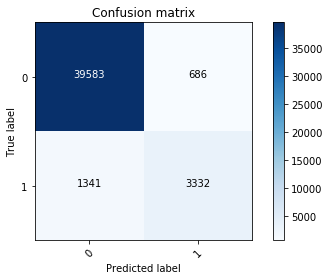

In [466]:
cnf_matrix = confusion_matrix(y_test, y_test_pred,labels=[0,1])
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=[0,1],
                      title='Confusion matrix')

In [467]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.97      0.98      0.98     40269
           1       0.83      0.71      0.77      4673

    accuracy                           0.95     44942
   macro avg       0.90      0.85      0.87     44942
weighted avg       0.95      0.95      0.95     44942



In [468]:
print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    161075
           1       1.00      1.00      1.00     18692

    accuracy                           1.00    179767
   macro avg       1.00      1.00      1.00    179767
weighted avg       1.00      1.00      1.00    179767



In [469]:
# Save the Modle to file in the current working directory

Best_RF_Mode_2 = "Pickle_RL_Model_2.pkl"  

#with open(Best_RF_Mode_2, 'wb') as file:  
    #pickle.dump(RF_clf_1, file)

In [470]:
loaded_model = pickle.load(open(Best_RF_Mode_2, 'rb'))
result = loaded_model.score(X_test, y_test)
print(result)

0.9548974233456455


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  70 out of  70 | elapsed:    0.0s finished


### LR

In [78]:
clf=SGDClassifier(penalty='l2')

prams={'alpha':[0.000001,0.00001,0.0001,0.00000001],'eta0':[0.1,0.01,0.001,0.0001],"tol":[0.001,0.0001,0.01,0.00001]} 



LR= RandomizedSearchCV(clf, param_distributions=prams,n_iter=4,
                                   cv=3,scoring='precision_macro',random_state=25,verbose=2,n_jobs=-1)

LR.fit(X_train,y_train)
LR.best_params_, LR.best_score_

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  12 | elapsed:   24.6s remaining:   49.3s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:   46.1s finished


({'tol': 0.001, 'eta0': 0.1, 'alpha': 1e-06}, 0.9446384299521644)

In [313]:

LR=SGDClassifier(eta0=0.1, alpha=0.000001,tol=0.001, loss='log', random_state=25, penalty='l2', 
                  verbose=1, learning_rate='constant',n_jobs=-1)

LR.fit(X_train,y_train)
#predictions_LR = LR.predict(X_te)

-- Epoch 1
Norm: 28.52, NNZs: 26, Bias: -30.477203, T: 179767, Avg. loss: 0.970165
Total training time: 0.04 seconds.
-- Epoch 2
Norm: 33.36, NNZs: 26, Bias: -36.180501, T: 359534, Avg. loss: 0.983009
Total training time: 0.07 seconds.
-- Epoch 3
Norm: 37.60, NNZs: 26, Bias: -39.655269, T: 539301, Avg. loss: 0.999831
Total training time: 0.12 seconds.
-- Epoch 4
Norm: 38.61, NNZs: 26, Bias: -42.912325, T: 719068, Avg. loss: 0.996405
Total training time: 0.15 seconds.
-- Epoch 5
Norm: 39.10, NNZs: 26, Bias: -43.802300, T: 898835, Avg. loss: 0.988110
Total training time: 0.19 seconds.
-- Epoch 6
Norm: 40.07, NNZs: 26, Bias: -45.608062, T: 1078602, Avg. loss: 0.996598
Total training time: 0.23 seconds.
Convergence after 6 epochs took 0.23 seconds


SGDClassifier(alpha=1e-06, eta0=0.1, learning_rate='constant', loss='log',
              n_jobs=-1, random_state=25, verbose=1)

In [314]:
y_train_pred = LR.predict(X_train)
y_test_pred = LR.predict(X_test)

Confusion matrix, without normalization
[[39309   960]
 [ 1255  3418]]


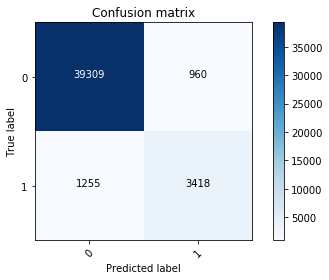

In [315]:
cnf_matrix = confusion_matrix(y_test, y_test_pred,labels=[0,1])
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=[0,1],
                      title='Confusion matrix')

In [316]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.97      0.98      0.97     40269
           1       0.78      0.73      0.76      4673

    accuracy                           0.95     44942
   macro avg       0.87      0.85      0.86     44942
weighted avg       0.95      0.95      0.95     44942



In [317]:
print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

           0       0.97      0.98      0.97    161075
           1       0.78      0.73      0.75     18692

    accuracy                           0.95    179767
   macro avg       0.87      0.85      0.86    179767
weighted avg       0.95      0.95      0.95    179767



### SVM

In [312]:
clf=SGDClassifier(penalty='l2',loss='hinge')

prams={'alpha':[0.000001,0.00001,0.0001,0.00000001],'eta0':[0.1,0.01,0.001,0.0001],"tol":[0.001,0.0001,0.01,0.00001]} 



LR= RandomizedSearchCV(clf, param_distributions=prams,n_iter=4,
                                   cv=3,scoring='recall_macro',random_state=25,verbose=2,n_jobs=-1)

LR.fit(X_train,y_train)
LR.best_params_, LR.best_score_

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  12 | elapsed:    8.0s remaining:   16.2s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:   14.6s finished


({'tol': 1e-05, 'eta0': 0.01, 'alpha': 1e-06}, 0.8744612708294982)

In [318]:
LR=SGDClassifier(eta0=0.01, alpha=0.0000001,tol=0.000001,loss='hinge', random_state=25, penalty='l2', 
                  verbose=1, learning_rate='constant',n_jobs=-1)

LR.fit(X_train,y_train)
#predictions_LR = LR.predict(X_te)

-- Epoch 1
Norm: 3.90, NNZs: 26, Bias: -4.330000, T: 179767, Avg. loss: 0.180455
Total training time: 0.03 seconds.
-- Epoch 2
Norm: 4.52, NNZs: 26, Bias: -5.120000, T: 359534, Avg. loss: 0.180443
Total training time: 0.05 seconds.
-- Epoch 3
Norm: 5.03, NNZs: 26, Bias: -5.580000, T: 539301, Avg. loss: 0.182080
Total training time: 0.08 seconds.
-- Epoch 4
Norm: 5.19, NNZs: 26, Bias: -5.980000, T: 719068, Avg. loss: 0.181781
Total training time: 0.12 seconds.
-- Epoch 5
Norm: 5.38, NNZs: 26, Bias: -6.200000, T: 898835, Avg. loss: 0.178935
Total training time: 0.14 seconds.
-- Epoch 6
Norm: 5.52, NNZs: 26, Bias: -6.400000, T: 1078602, Avg. loss: 0.181425
Total training time: 0.17 seconds.
-- Epoch 7
Norm: 5.78, NNZs: 26, Bias: -6.520000, T: 1258369, Avg. loss: 0.179908
Total training time: 0.20 seconds.
-- Epoch 8
Norm: 5.80, NNZs: 26, Bias: -6.800000, T: 1438136, Avg. loss: 0.178859
Total training time: 0.22 seconds.
-- Epoch 9
Norm: 5.90, NNZs: 26, Bias: -6.890000, T: 1617903, Avg. lo

SGDClassifier(alpha=1e-07, eta0=0.01, learning_rate='constant', n_jobs=-1,
              random_state=25, tol=1e-06, verbose=1)

In [319]:
y_train_pred = LR.predict(X_train)
y_test_pred = LR.predict(X_test)

Confusion matrix, without normalization
[[40184    85]
 [ 1618  3055]]


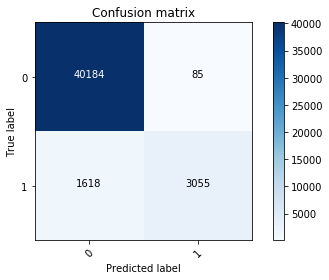

In [320]:
cnf_matrix = confusion_matrix(y_test, y_test_pred,labels=[0,1])
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=[0,1],
                      title='Confusion matrix')

In [321]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98     40269
           1       0.97      0.65      0.78      4673

    accuracy                           0.96     44942
   macro avg       0.97      0.83      0.88     44942
weighted avg       0.96      0.96      0.96     44942



### Remaining class labels classification

In [333]:
Attack_df=df[df['PKT_CLASS']!=0]

In [334]:
new_Attack_df=Attack_df[Attack_df['PKT_CLASS']!=1]
new_Attack_df.head()

,SRC_ADD,DES_ADD,PKT_ID,FROM_NODE,TO_NODE,PKT_TYPE,PKT_SIZE,FLAGS,FID,SEQ_NUMBER,...,PKT_DELAY,PKT_SEND_TIME,PKT_RESEVED_TIME,FIRST_PKT_SENT,LAST_PKT_RESEVED,PKT_CLASS,new_class,PKT_TYPE_encode,NODE_NAME_FROM_encode,NODE_NAME_TO_encode
17,24.6,6.00,13859.0,23.0,21.0,ack,55.0,0,7.0,423.0,...,0.000000,2.514346,2.544355,1.030048,50.059112,2,1,0,42,44
19,2.0,24.16,46094.0,2.0,21.0,ping,65535.0,0,0.0,-1.0,...,0.056214,44.000000,44.056214,0.000000,9.056214,2,1,2,32,44
93,20.0,25.00,74641.0,20.0,21.0,tcp,55.0,0,0.0,44.0,...,0.073780,70.758269,70.832049,1.201267,75.999728,3,1,3,40,44
210,10.0,24.11,4312.0,10.0,22.0,ping,65535.0,0,0.0,-1.0,...,0.050971,5.000000,5.050971,0.000000,9.050971,2,1,2,22,45
265,24.6,6.00,10480.0,23.0,21.0,ack,55.0,0,7.0,318.0,...,0.000000,2.196557,2.226566,1.030048,50.059112,2,1,0,42,44


In [390]:
y = new_Attack_df['PKT_CLASS'].values  # separated the class lable in Y
X = new_Attack_df.drop(['PKT_CLASS','new_class','PKT_TYPE','NODE_NAME_FROM','NODE_NAME_TO','FLAGS'], axis=1)   # combined all the features into X
X.head(1)

,SRC_ADD,DES_ADD,PKT_ID,FROM_NODE,TO_NODE,PKT_SIZE,FID,SEQ_NUMBER,NUMBER_OF_PKT,NUMBER_OF_BYTE,...,PKT_AVG_SIZE,UTILIZATION,PKT_DELAY,PKT_SEND_TIME,PKT_RESEVED_TIME,FIRST_PKT_SENT,LAST_PKT_RESEVED,PKT_TYPE_encode,NODE_NAME_FROM_encode,NODE_NAME_TO_encode
17,24.6,6.0,13859.0,23.0,21.0,55.0,7.0,423.0,16091.0,885005.0,...,55.0,0.00844,0.0,2.514346,2.544355,1.030048,50.059112,0,42,44


In [391]:
# train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20,shuffle=True,stratify=y )

In [392]:
def normalizer_1(a):
    from sklearn.preprocessing import StandardScaler
    normalizer_= StandardScaler()
    normalizer_.fit(a.reshape(-1,1))

    return normalizer_


In [393]:
def scaler_2(x):
    scaler=[]
    for i in range(0,x.shape[1]):
        X=x[0:x.shape[0],i:i+1]
        scaler.append(normalizer_1(X))
        
    return (scaler)  


In [394]:
scale_2=scaler_2(X_train.values)

In [400]:

# Save the Modle to file in the current working directory

Standardscale_2 = "Standard_scale_2.pkl"  

#with open(Standardscale_2, 'wb') as file:  
    #pickle.dump(scale_2, file)

In [397]:
def normalizer(a,b):
    
    from sklearn.preprocessing import StandardScaler
    normalizer_= StandardScaler()
    normalizer_.fit(a.reshape(-1,1))
    X_train = normalizer_.transform(a.reshape(-1,1))

    X_test= normalizer_.transform(b.reshape(-1,1))
    return X_train,X_test

In [398]:
X_train['SRC_ADD'],X_test['SRC_ADD']=normalizer(X_train['SRC_ADD'].values,X_test['SRC_ADD'].values)
X_train['DES_ADD'],X_test['DES_ADD']=normalizer(X_train['DES_ADD'].values,X_test['DES_ADD'].values)
X_train['PKT_ID'],X_test['PKT_ID']=normalizer(X_train['PKT_ID'].values,X_test['PKT_ID'].values)

X_train['PKT_SIZE'],X_test['PKT_SIZE']=normalizer(X_train['PKT_SIZE'].values,X_test['PKT_SIZE'].values)
X_train['FID'],X_test['FID']=normalizer(X_train['FID'].values,X_test['FID'].values)
X_train['SEQ_NUMBER'],X_test['SEQ_NUMBER']=normalizer(X_train['SEQ_NUMBER'].values,X_test['SEQ_NUMBER'].values)
X_train['NUMBER_OF_PKT'],X_test['NUMBER_OF_PKT']=normalizer(X_train['NUMBER_OF_PKT'].values,X_test['NUMBER_OF_PKT'].values)
X_train['NUMBER_OF_BYTE'],X_test['NUMBER_OF_BYTE']=normalizer(X_train['NUMBER_OF_BYTE'].values,X_test['NUMBER_OF_BYTE'].values)

X_train['PKT_IN'],X_test['PKT_IN']=normalizer(X_train['PKT_IN'].values,X_test['PKT_IN'].values)
X_train['PKT_R'],X_test['PKT_R']=normalizer(X_train['PKT_R'].values,X_test['PKT_R'].values)
X_train['PKT_OUT'],X_test['PKT_OUT']=normalizer(X_train['PKT_OUT'].values,X_test['PKT_OUT'].values)
X_train['PKT_RATE'],X_test['PKT_RATE']=normalizer(X_train['PKT_RATE'].values,X_test['PKT_RATE'].values)
X_train['BYTE_RATE'],X_test['BYTE_RATE']=normalizer(X_train['BYTE_RATE'].values,X_test['BYTE_RATE'].values)
X_train['PKT_AVG_SIZE'],X_test['PKT_AVG_SIZE']=normalizer(X_train['PKT_AVG_SIZE'].values,X_test['PKT_AVG_SIZE'].values)
X_train['UTILIZATION'],X_test['UTILIZATION']=normalizer(X_train['UTILIZATION'].values,X_test['UTILIZATION'].values)
X_train['PKT_DELAY'],X_test['PKT_DELAY']=normalizer(X_train['PKT_DELAY'].values,X_test['PKT_DELAY'].values)
X_train['PKT_SEND_TIME'],X_test['PKT_SEND_TIME']=normalizer(X_train['PKT_SEND_TIME'].values,X_test['PKT_SEND_TIME'].values)
X_train['PKT_RESEVED_TIME'],X_test['PKT_RESEVED_TIME']=normalizer(X_train['PKT_RESEVED_TIME'].values,X_test['PKT_RESEVED_TIME'].values)
X_train['FIRST_PKT_SENT'],X_test['FIRST_PKT_SENT']=normalizer(X_train['FIRST_PKT_SENT'].values,X_test['FIRST_PKT_SENT'].values)
X_train['LAST_PKT_RESEVED'],X_test['LAST_PKT_RESEVED']=normalizer(X_train['LAST_PKT_RESEVED'].values,X_test['LAST_PKT_RESEVED'].values)
X_train['PKT_DELAY_NODE'],X_test['PKT_DELAY_NODE']=normalizer(X_train['PKT_DELAY_NODE'].values,X_test['PKT_DELAY_NODE'].values)
X_train['FROM_NODE'],X_test['FROM_NODE']=normalizer(X_train['FROM_NODE'].values,X_test['FROM_NODE'].values)
X_train['TO_NODE'],X_test['TO_NODE']=normalizer(X_train['TO_NODE'].values,X_test['TO_NODE'].values)
X_train['NODE_NAME_FROM_encode'],X_test['NODE_NAME_FROM_encode']=normalizer(X_train['NODE_NAME_FROM_encode'].values,X_test['NODE_NAME_FROM_encode'].values)
X_train['NODE_NAME_TO_encode'],X_test['NODE_NAME_TO_encode']=normalizer(X_train['NODE_NAME_TO_encode'].values,X_test['NODE_NAME_TO_encode'].values)
X_train['PKT_TYPE_encode'],X_test['PKT_TYPE_encode']=normalizer(X_train['PKT_TYPE_encode'].values,X_test['PKT_TYPE_encode'].values)


In [399]:
X_train

,SRC_ADD,DES_ADD,PKT_ID,FROM_NODE,TO_NODE,PKT_SIZE,FID,SEQ_NUMBER,NUMBER_OF_PKT,NUMBER_OF_BYTE,...,PKT_AVG_SIZE,UTILIZATION,PKT_DELAY,PKT_SEND_TIME,PKT_RESEVED_TIME,FIRST_PKT_SENT,LAST_PKT_RESEVED,PKT_TYPE_encode,NODE_NAME_FROM_encode,NODE_NAME_TO_encode
1406489,0.696315,0.471560,-0.456390,0.234782,0.252107,-0.646083,-0.529204,-0.097230,-0.022911,-0.853837,...,-0.646082,-0.853838,0.384666,1.037069,1.037105,-0.193031,1.075636,0.680586,0.527200,0.023260
991356,0.696315,0.471560,-0.439922,0.234782,0.252107,-0.646083,-0.529204,-0.097230,-0.022911,-0.853837,...,-0.646082,-0.853838,0.384666,1.156033,1.156041,-0.193031,1.075636,0.680586,0.527200,0.023260
1837818,-0.233078,0.365079,0.884295,-1.198856,-0.020837,-0.609939,3.450351,-0.094080,-0.156421,-0.168137,...,-0.609939,-0.168131,-1.197962,-0.621295,-0.622676,3.643122,1.041195,-1.144464,-3.576269,0.427075
267311,0.696315,0.471560,-0.410605,0.593192,0.797996,-0.646083,-0.529204,-0.097230,-0.022911,-0.853837,...,-0.646082,-0.853838,0.384666,1.371893,1.371847,-0.193031,1.075636,0.680586,0.316766,0.561681
2030194,-0.515936,0.331704,-0.756935,0.413987,0.252107,1.644786,-0.529204,-0.097592,-1.122174,0.573655,...,1.644781,0.573659,0.164064,-1.141644,-1.141517,-0.386665,-1.284244,0.680586,0.632418,0.023260
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1427836,1.255298,-1.117716,0.331942,0.413987,-1.931447,-0.646083,1.343528,-0.046588,1.417244,-0.795874,...,-0.646082,-0.795867,-1.215698,-0.989018,-0.990354,-0.220630,0.161150,-2.056988,0.632418,-4.687921
233179,1.251257,-1.594499,-0.350744,0.593192,-0.020837,-0.646083,0.992390,-0.075860,1.419003,-0.795803,...,-0.646082,-0.795806,-1.215698,-1.487464,-1.488677,-0.220633,0.160827,-2.056988,0.316766,0.427075
2041727,-0.785326,0.455668,2.424948,-1.915675,-0.293782,-0.589285,0.641253,0.028509,1.416125,1.998943,...,-0.589285,1.998949,-1.181572,0.295023,0.293457,-0.225473,0.160087,0.680586,-2.103229,0.292470
1215365,0.022842,0.339650,-0.763295,-0.840447,-0.020837,1.858360,-0.529204,-0.097592,-1.122174,0.710869,...,1.858362,0.710865,1.105697,-1.186970,-1.184932,-0.386665,-1.282766,-0.231939,-1.261492,0.427075


### Random Forest Model

In [251]:


param_dist = {"n_estimators":[30,50,80,100],
              "max_depth": [80,90,100,120],
              "min_samples_split": [5,10,20,50,80,100],
              "min_samples_leaf":[2,4,24,36]
             ,'max_leaf_nodes':[2,5,10,20,50,80]}

clf = RandomForestClassifier(random_state=25,n_jobs=-1)

rf_random = RandomizedSearchCV(clf, param_distributions=param_dist,
                                   n_iter=5,cv=3,scoring='recall_macro',random_state=25,verbose=2)

rf_random.fit(X_train,y_train)
print('mean test scores',rf_random.cv_results_['mean_test_score'])
#print('mean train scores',rf_random.cv_results_['mean_train_score'])
rf_random.best_params_, rf_random.best_score_

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] n_estimators=30, min_samples_split=10, min_samples_leaf=2, max_leaf_nodes=2, max_depth=100 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  n_estimators=30, min_samples_split=10, min_samples_leaf=2, max_leaf_nodes=2, max_depth=100, total=   4.0s
[CV] n_estimators=30, min_samples_split=10, min_samples_leaf=2, max_leaf_nodes=2, max_depth=100 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.9s remaining:    0.0s


[CV]  n_estimators=30, min_samples_split=10, min_samples_leaf=2, max_leaf_nodes=2, max_depth=100, total=   0.4s
[CV] n_estimators=30, min_samples_split=10, min_samples_leaf=2, max_leaf_nodes=2, max_depth=100 
[CV]  n_estimators=30, min_samples_split=10, min_samples_leaf=2, max_leaf_nodes=2, max_depth=100, total=   0.2s
[CV] n_estimators=80, min_samples_split=10, min_samples_leaf=4, max_leaf_nodes=20, max_depth=80 
[CV]  n_estimators=80, min_samples_split=10, min_samples_leaf=4, max_leaf_nodes=20, max_depth=80, total=   0.4s
[CV] n_estimators=80, min_samples_split=10, min_samples_leaf=4, max_leaf_nodes=20, max_depth=80 
[CV]  n_estimators=80, min_samples_split=10, min_samples_leaf=4, max_leaf_nodes=20, max_depth=80, total=   0.5s
[CV] n_estimators=80, min_samples_split=10, min_samples_leaf=4, max_leaf_nodes=20, max_depth=80 
[CV]  n_estimators=80, min_samples_split=10, min_samples_leaf=4, max_leaf_nodes=20, max_depth=80, total=   0.5s
[CV] n_estimators=100, min_samples_split=10, min_sam

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:   12.3s finished


mean test scores [0.64 0.95 0.95 0.95 0.64]


({'n_estimators': 80,
  'min_samples_split': 10,
  'min_samples_leaf': 4,
  'max_leaf_nodes': 20,
  'max_depth': 80},
 0.954743142557787)

In [125]:
RF_clf_2=RandomForestClassifier(n_estimators=80,
  min_samples_split=10,
  min_samples_leaf=4,
  max_depth=80,verbose=1,n_jobs=-1)

RF_clf_2.fit(X_train,y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    0.3s finished


RandomForestClassifier(max_depth=80, min_samples_leaf=4, min_samples_split=10,
                       n_estimators=80, n_jobs=-1, verbose=1)

In [126]:
y_train_pred = RF_clf_2.predict(X_train)
y_test_pred = RF_clf_2.predict(X_test)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  80 out of  80 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  80 out of  80 | elapsed:    0.0s finished


Confusion matrix, without normalization
[[2433   70   15]
 [  72 1261    0]
 [   2   46  774]]


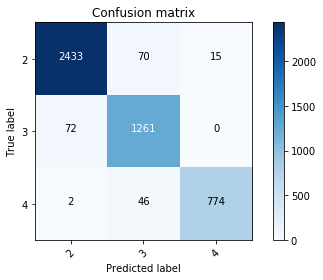

In [127]:
cnf_matrix = confusion_matrix(y_test, y_test_pred,labels=[2,3,4])
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=[2,3,4],
                      title='Confusion matrix')

In [128]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           2       0.97      0.97      0.97      2518
           3       0.92      0.95      0.93      1333
           4       0.98      0.94      0.96       822

    accuracy                           0.96      4673
   macro avg       0.96      0.95      0.95      4673
weighted avg       0.96      0.96      0.96      4673



# Saving Model

In [129]:
# Save the Modle to file in the current working directory

Best_RF_Mode_3 = "Pickle_RL_Model_3.pkl"  

with open(Best_RF_Mode_3, 'wb') as file:  
    pickle.dump(RF_clf_2, file)

In [130]:
loaded_model = pickle.load(open(Best_RF_Mode_3, 'rb'))
result = loaded_model.score(X_test, y_test)
print(result)

0.9561309651187674


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  80 out of  80 | elapsed:    0.0s finished


In [ ]:
getting scores above 90% without upsampling

### LR

In [496]:
clf=SGDClassifier(penalty='l2',loss='log')

prams={'alpha':[0.000001,0.00001,0.0001,0.00000001],'eta0':[0.1,0.01,0.001,0.0001],"tol":[0.001,0.0001,0.01,0.00001]} 



LR= RandomizedSearchCV(clf, param_distributions=prams,n_iter=4,
                                   cv=3,scoring='precision_macro',random_state=25,verbose=2,n_jobs=-1)

LR.fit(X_train,y_train)
LR.best_params_, LR.best_score_

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  12 | elapsed:    4.8s remaining:    9.7s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    6.2s finished


({'tol': 1e-05, 'eta0': 0.01, 'alpha': 1e-06}, 0.9596685101638719)

In [497]:

LR=SGDClassifier(eta0=0.01, alpha=1e-06,tol=0.000001, loss='log', random_state=25, penalty='l2', 
                  verbose=1, learning_rate='constant',n_jobs=-1)

LR.fit(X_train,y_train)
#predictions_LR = LR.predict(X_te)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s finished


-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 3.85, NNZs: 26, Bias: -0.296308, T: 18692, Avg. loss: 0.249343
Total training time: 0.01 seconds.
-- Epoch 2
Norm: 5.13, NNZs: 26, Bias: -1.047424, T: 18692, Avg. loss: 0.141308
Total training time: 0.01 seconds.
-- Epoch 2
Norm: 3.22, NNZs: 26, Bias: -1.274728, T: 18692, Avg. loss: 0.208935
Total training time: 0.01 seconds.
-- Epoch 2
Norm: 4.77, NNZs: 26, Bias: -0.362621, T: 37384, Avg. loss: 0.224155
Total training time: 0.01 seconds.
-- Epoch 3
Norm: 6.46, NNZs: 26, Bias: -1.664927, T: 37384, Avg. loss: 0.092710
Total training time: 0.01 seconds.
-- Epoch 3
Norm: 3.59, NNZs: 26, Bias: -1.657729, T: 37384, Avg. loss: 0.196885
Total training time: 0.01 seconds.
-- Epoch 3
Norm: 5.56, NNZs: 26, Bias: -0.532941, T: 56076, Avg. loss: 0.214747
Total training time: 0.01 seconds.
-- Epoch 4
Norm: 7.34, NNZs: 26, Bias: -2.158175, T: 56076, Avg. loss: 0.079831
Total training time: 0.01 seconds.
-- Epoch 4
Norm: 6.25, NNZs: 26, Bias: -0.682331, T: 74768

SGDClassifier(alpha=1e-06, eta0=0.01, learning_rate='constant', loss='log',
              n_jobs=-1, random_state=25, tol=1e-06, verbose=1)

In [498]:
y_train_pred = LR.predict(X_train)
y_test_pred = LR.predict(X_test)

Confusion matrix, without normalization
[[2434   71   13]
 [  80 1253    0]
 [   0   51  771]]


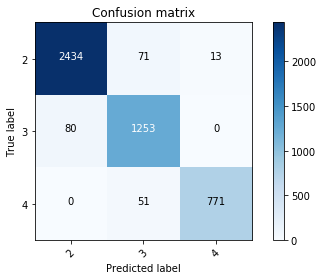

In [499]:
cnf_matrix = confusion_matrix(y_test, y_test_pred,labels=[2,3,4])
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=[2,3,4],
                      title='Confusion matrix')

In [500]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           2       0.97      0.97      0.97      2518
           3       0.91      0.94      0.93      1333
           4       0.98      0.94      0.96       822

    accuracy                           0.95      4673
   macro avg       0.95      0.95      0.95      4673
weighted avg       0.95      0.95      0.95      4673



### GBDT

In [502]:

clf=XGBClassifier()

prams={
     'n_estimators':[20,50,80,100,120,140,160,200],
    'subsample':[1,0.15,0.10,0.35,0.60],
    'min_child_weight' : [5,10,20,50,80],
    'learning_rate':[0.001, 0.75, 0.5, 0.1],
        'max_depth':[20,40,60,80,90,100]
     }

XG_boost= RandomizedSearchCV(clf, param_distributions=prams,
                                   n_iter=4,cv=3,scoring='recall_macro',random_state=25)

XG_boost.fit(X_train,y_train)
XG_boost.best_params_, XG_boost.best_score_


({'subsample': 0.6,
  'n_estimators': 80,
  'min_child_weight': 50,
  'max_depth': 60,
  'learning_rate': 0.5},
 0.9554634723868176)

In [506]:
XG_boost=XGBClassifier(subsample=0.6,max_depth=60,n_estimators=80,learning_rate=0.5,min_child_weight=50
                       ,verbose=2,n_jobs=-1)

XG_boost.fit(X_train,y_train)

[04:34:02] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.5, max_delta_step=0, max_depth=60,
              min_child_weight=50, missing=nan, monotone_constraints='()',
              n_estimators=80, n_jobs=-1, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=0.6,
              tree_method='exact', validate_parameters=1, verbose=2,
              verbosity=None)

In [507]:
y_train_pred = XG_boost.predict(X_train)
y_test_pred = XG_boost.predict(X_test)

Confusion matrix, without normalization
[[2439   69   10]
 [  80 1253    0]
 [   0   51  771]]


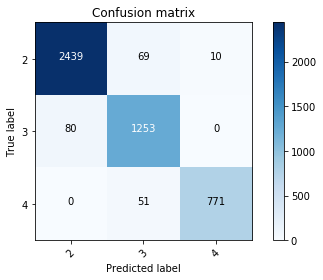

In [510]:
cnf_matrix = confusion_matrix(y_test, y_test_pred,labels=[2,3,4])
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=[2,3,4],
                      title='Confusion matrix')

In [509]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           2       0.97      0.97      0.97      2518
           3       0.91      0.94      0.93      1333
           4       0.99      0.94      0.96       822

    accuracy                           0.96      4673
   macro avg       0.96      0.95      0.95      4673
weighted avg       0.96      0.96      0.96      4673



### Separating test set for evaluating all the models

### Testing binary test data on 5 class classification Model and ensembel binary Model

In [178]:
class_5_model = pickle.load(open('five_class_Model.pkl', 'rb'))

result_5_class_1 = class_5_model.fit(X_tr, y_train)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 50building tree 2 of 50
building tree 3 of 50
building tree 4 of 50building tree 5 of 50
building tree 6 of 50


building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  3.0min


building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 of 50
building tree 47 of 50
building tree 48 of 50
building tree 49 of 50
building tree 50 of 50


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  5.2min finished


In [180]:
y_train_pred = result_5_class_1.predict(X_tr)
y_test_pred = result_5_class_1.predict(X_test)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:   11.1s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:   19.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    2.2s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    3.9s finished


Confusion matrix, without normalization
[[379012   8180]
 [  5510  39432]]


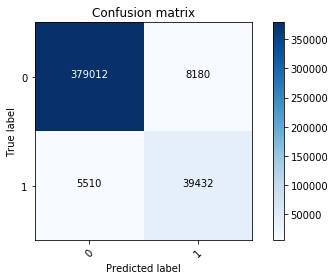

In [183]:
cnf_matrix = confusion_matrix(y_test, y_test_pred,labels=[0,1])
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=[0,1],
                      title='Confusion matrix')

In [184]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.99      0.98      0.98    387192
           1       0.83      0.88      0.85     44942

    accuracy                           0.97    432134
   macro avg       0.91      0.93      0.92    432134
weighted avg       0.97      0.97      0.97    432134



### Binary classification upon normal and attack traffic

In [185]:
load_model_1 = pickle.load(open('Pickle_RL_Model_1.pkl', 'rb'))

result_binary_1 = load_model_1.fit(X_tr, y_train)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 50
building tree 2 of 50building tree 3 of 50
building tree 4 of 50building tree 5 of 50
building tree 6 of 50
building tree 7 of 50

building tree 8 of 50

building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  3.2min


building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 of 50
building tree 47 of 50
building tree 48 of 50
building tree 49 of 50
building tree 50 of 50


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  5.1min finished


In [186]:
y_train_pred = result_binary_1.predict(X_tr)
y_test_pred = result_binary_1.predict(X_test)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    5.8s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    9.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    1.0s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    1.8s finished


Confusion matrix, without normalization
[[386647    545]
 [  5647  39295]]


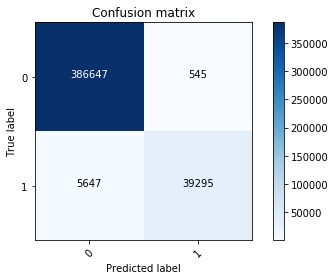

In [187]:
cnf_matrix = confusion_matrix(y_test, y_test_pred,labels=[0,1])
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=[0,1],
                      title='Confusion matrix')


In [188]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99    387192
           1       0.99      0.87      0.93     44942

    accuracy                           0.99    432134
   macro avg       0.99      0.94      0.96    432134
weighted avg       0.99      0.99      0.99    432134



#### Testing second binary test data of on label-1 and rest attack with 5 class classification Model and second ensembel binary Model

In [201]:

class_5_model = pickle.load(open('five_class_Model.pkl', 'rb'))

result_5_class_1 = class_5_model.fit(X_train, y_train)



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50building tree 5 of 50

building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50building tree 24 of 50

building tree 25 of 50
building tree 26 of 50
building tree 27 of 50building tree 28 of 50

building tree 29 of 50
building tree 30 of 50building tree 31 of 50

building tree 32 of 50


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.7s


building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 of 50
building tree 47 of 50
building tree 48 of 50
building tree 49 of 50
building tree 50 of 50


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    3.1s finished


In [202]:
y_train_pred = result_5_class_1.predict(X_train)
y_test_pred = result_5_class_1.predict(X_test)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.0s finished


Confusion matrix, without normalization
[[39636   633]
 [ 1422  3251]]


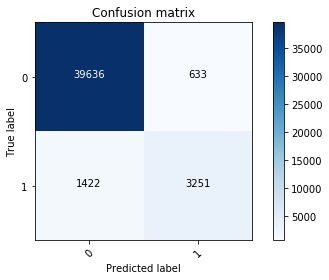

In [203]:
cnf_matrix = confusion_matrix(y_test, y_test_pred,labels=[0,1])
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=[0,1],
                      title='Confusion matrix')

In [204]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.97      0.98      0.97     40269
           1       0.84      0.70      0.76      4673

    accuracy                           0.95     44942
   macro avg       0.90      0.84      0.87     44942
weighted avg       0.95      0.95      0.95     44942



### Testing binary test data on ensembel binary class classification

In [205]:

load_model_2 = pickle.load(open('Pickle_RL_Model_2.pkl', 'rb'))

result_binary_2 = load_model_2.fit(X_train, y_train)



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:    4.0s finished


In [206]:
y_train_pred = result_binary_2.predict(X_train)
y_test_pred = result_binary_2.predict(X_test)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  70 out of  70 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  70 out of  70 | elapsed:    0.0s finished


Confusion matrix, without normalization
[[39490   779]
 [ 1370  3303]]


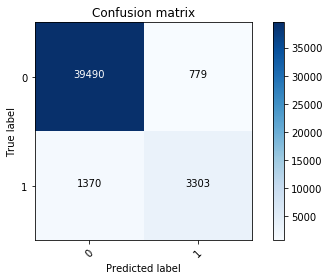

In [207]:
cnf_matrix = confusion_matrix(y_test, y_test_pred,labels=[0,1])
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=[0,1],
                      title='Confusion matrix')

In [208]:

print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.97      0.98      0.97     40269
           1       0.81      0.71      0.75      4673

    accuracy                           0.95     44942
   macro avg       0.89      0.84      0.86     44942
weighted avg       0.95      0.95      0.95     44942



### Testing 3 class classification test data on 5 class classification and origial 3 class model

In [216]:


class_5_model = pickle.load(open('five_class_Model.pkl', 'rb'))

result_5_class_1 = class_5_model.fit(X_train, y_train)




[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    0.1s


building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50building tree 14 of 50

building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50building tree 29 of 50

building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50building tree 37 of 50

building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 

[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished


In [217]:
y_train_pred = result_5_class_1.predict(X_train)
y_test_pred = result_5_class_1.predict(X_test)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.0s finished


Confusion matrix, without normalization
[[2433   69   16]
 [  90 1234    9]
 [   0   42  780]]


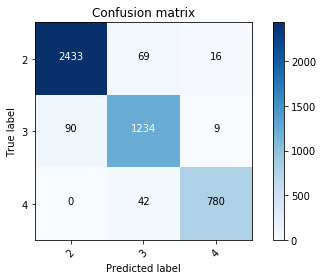

In [218]:
cnf_matrix = confusion_matrix(y_test, y_test_pred,labels=[2,3,4])
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=[2,3,4],
                      title='Confusion matrix')

In [219]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           2       0.96      0.97      0.97      2518
           3       0.92      0.93      0.92      1333
           4       0.97      0.95      0.96       822

    accuracy                           0.95      4673
   macro avg       0.95      0.95      0.95      4673
weighted avg       0.95      0.95      0.95      4673



### Testing 3-class classification with test data on ensembel binary class classification

In [224]:

load_model_3 = pickle.load(open('Pickle_RL_Model_3.pkl', 'rb'))

result_binary_3 = load_model_3.fit(X_train, y_train)



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    0.4s finished


In [225]:
y_train_pred = result_binary_3.predict(X_train)
y_test_pred = result_binary_3.predict(X_test)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  80 out of  80 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  80 out of  80 | elapsed:    0.0s finished


Confusion matrix, without normalization
[[2433   69   16]
 [  68 1265    0]
 [   0   43  779]]


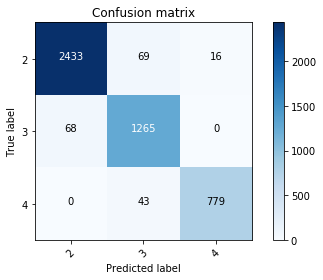

In [226]:

cnf_matrix = confusion_matrix(y_test, y_test_pred,labels=[2,3,4])
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=[2,3,4],
                      title='Confusion matrix')


In [227]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           2       0.97      0.97      0.97      2518
           3       0.92      0.95      0.93      1333
           4       0.98      0.95      0.96       822

    accuracy                           0.96      4673
   macro avg       0.96      0.95      0.96      4673
weighted avg       0.96      0.96      0.96      4673



In [229]:
from prettytable import PrettyTable

x = PrettyTable()
x.field_names = ["Model", "Best Model", "precision macro","recall macro","F1"]

x.add_row(['Singel_Model-1','RF with 5 classification on 1st test set',0.91,0.92,0.93])  
x.add_row(['Ensembel-1','RF with 1st binary classification on 1st test set', 0.99,0.94,0.96]) 
x.add_row(['Singel_Model-1','RF with 5 classification on 2nd test set',0.90,0.84,0.87])  
x.add_row(['Ensembel-2','RF with 2nd binary classification on 2nd test set',  0.89,0.84,0.86]) 
x.add_row(['Singel_Model-1','RF with 5 classification on 3rd test set',0.95 ,0.95,0.95])  
x.add_row(['Ensembel-3','RF with last 3-class classification on 3rd test set', 0.96 ,0.95,0.96]) 

print(x)


+----------------+-----------------------------------------------------+-----------------+--------------+------+
|     Model      |                      Best Model                     | precision macro | recall macro |  F1  |
+----------------+-----------------------------------------------------+-----------------+--------------+------+
| Singel_Model-1 |       RF with 5 classification on 1st test set      |       0.91      |     0.92     | 0.93 |
|   Ensembel-1   |  RF with 1st binary classification on 1st test set  |       0.99      |     0.94     | 0.96 |
| Singel_Model-1 |       RF with 5 classification on 2nd test set      |       0.9       |     0.84     | 0.87 |
|   Ensembel-2   |  RF with 2nd binary classification on 2nd test set  |       0.89      |     0.84     | 0.86 |
| Singel_Model-1 |       RF with 5 classification on 3rd test set      |       0.95      |     0.95     | 0.95 |
|   Ensembel-3   | RF with last 3-class classification on 3rd test set |       0.96      |     0

In [2]:
from prettytable import PrettyTable

x = PrettyTable()
x.field_names = ["No","Content",]

x.add_row(['1.','Introduction '])  
x.add_row(['2.','Source of the Dataset ']) 
x.add_row(['3.','Business Problem '])  
x.add_row(['4.','ML formulation ']) 
x.add_row(['5','Existing Approach '])  
x.add_row(['6.','My Improvements ']) 
x.add_row(['7.','EDA '])
x.add_row(['8.','First Cut Approach  '])  
x.add_row(['9.','Model Explanation  ']) 
x.add_row(['10.','Future Works  ']) 
x.add_row(['11.','Profile ']) 
x.add_row(['12.','Reference ']) 

print(x)

+-----+------------------------+
|  No |        Content         |
+-----+------------------------+
|  1. |     Introduction       |
|  2. | Source of the Dataset  |
|  3. |   Business Problem     |
|  4. |    ML formulation      |
|  5  |   Existing Approach    |
|  6. |    My Improvements     |
|  7. |          EDA           |
|  8. |  First Cut Approach    |
|  9. |  Model Explanation     |
| 10. |     Future Works       |
| 11. |        Profile         |
| 12. |       Reference        |
+-----+------------------------+
